# Predicting GPA with Deep Learning
This notebook reproduces the models and all figures and tables contained in my paper on the Fragile Familes Challenge.

***Please note the following if you intend to run this notebook***

- To the best of my knowledge this notebook will reproduce all the results accurately but due to stochastic nature of many of the processes used the results may differ. Where possible I have created static copies of objects that can be loaded directly. Some of these are too large to store on Github, for example the pickled versions of the final 5 classifiers. Please email me directly if you would like copies of these.

- This notebook is contains process that are computationally intensive and take some time to run. As is it will take at least 24 hours to run on a top spec laptop computer. I have noted the cells that take most time to run. If possible you may consider editing the notebook where appropriate to run processes in paraellel or using a GPU.




# Loading packages and data

In [2]:
# Set up to ensure reproducibility following https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import tensorflow as tf
import numpy as np
import random
import os

os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(67891)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(54321)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(56789)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

seed = 13579 # used below to seed sklearn functions

import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping, CSVLogger, History
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Loading the files

***Note: These data cannot be provided on Github and I will delete my copies in accordance with the FFC agreement. If you would like copies of the data to replicate these analyses please consult the Fragile Families and Child Wellbeing Survey [website](https://fragilefamilies.princeton.edu/documentation).***

In [67]:
train=pd.read_csv('../../FFChallenge_v2/train.csv',low_memory=False, index_col='challengeID')
predictions=pd.read_csv('../../FFChallenge_v2/prediction.csv',low_memory=False, index_col='challengeID')

To generate `full_imputed.p` the script `clean_files.py` must first be run. If necessary it can be executed by uncommenting (deleting the #) and running the line below.

In [68]:
#! PYTHONHASHSEED=0 python3 ../preprocess/clean_files.py

In [69]:
#data = pd.read_csv('../../ff_files/full_imputed.csv') # load imputed data output after running the clean_files.py
data = pd.read_csv('../data/full_imputed.csv') # load imputed data output after running the clean_files.py

In [70]:
data.shape

(4242, 4569)

In [71]:
data.head()

,challengeID,m1lenmin,m1citywt,m1e1d1,m1e1d2,m1e1d3,m1i2a,m1i2b,m1j2a,m1j2b,...,hv4mflag,hv4mompreg,hv4selfht,hv4selfwt,gpa,grit,materialHardship,eviction,layoff,jobTraining
0,1,40.0,202.485367,25.0,6.723174,13.260396,38.0,1682.415602,0.038262,2.211822,...,0.0,0.0,0.0,0.0,2.5,3.50,0.090909,0.0,0.0,0.0
1,2,40.0,45.608219,43.0,16.000000,3.000000,25.0,3050.504448,0.110909,1.985703,...,0.0,1.0,0.0,0.0,2.5,3.25,0.181818,0.0,0.0,0.0
2,3,35.0,39.060299,49.0,46.000000,23.000000,20.0,0.000000,12.158179,1.386592,...,0.0,0.0,0.0,0.0,2.5,3.00,0.000000,0.0,0.0,0.0
3,4,30.0,22.304855,23.0,23.169628,5.699719,20.0,0.000000,4.165048,1.157385,...,0.0,0.0,0.0,0.0,2.5,3.50,0.090909,0.0,0.0,0.0
4,5,25.0,35.518272,90.0,64.000000,58.000000,12.0,1974.812374,12.212538,2.965919,...,0.0,0.0,0.0,0.0,2.5,3.50,0.090909,0.0,0.0,0.0


In [72]:
data.index = data['challengeID']
del data['challengeID']

Extract the outcomes from the imputed data.

In [74]:
y = data[['gpa','grit','materialHardship','eviction','layoff','jobTraining']]
X = data
for c in X.columns:
    if c in list(y.columns):
        del X[c]

# Data processing

Before modelling the data there are two types of transformations that I use to optimize them for the neural network.

Categorical variables are transformed using one-hot encoding. Continuous variables are also normalized to have a mean of zero.

To identify which columns belong to which group I use same heuristic as in the imputation script.

In [75]:
# Identify categorical columns
cat_cols = []
non_cat_cols = []
for i, c in enumerate(X.columns):
    is_categorical = False
    vals = set(list(X[c]))
    vals = {x for x in vals if x==x} # Removes nans, otherwise treated as unique
    if X[c].dtype == 'float64': # if float and low num distinct then treat as cat
        if len(vals) <= 20:
            is_categorical = True
        else:
            pass
    else:
        is_categorical = True
    
    # Now append to relevant list of columns
    if is_categorical:
        cat_cols.append(c)
        
    else:
        non_cat_cols.append(c)

In [76]:
X_dummies = pd.get_dummies(X, columns=cat_cols)
# Note that sklearn also has one-hot encoding but doesn't relabel

In [77]:
X_dummies.head()

,m1lenmin,m1citywt,m1e1d1,m1e1d2,m1e1d3,m1i2a,m1i2b,m1j2a,m1j2b,cm1hhinc,...,hv4mflag_1.0,hv4mflag_2.0,hv4mflag_3.0,hv4mompreg_0.0,hv4mompreg_1.0,hv4selfht_0.0,hv4selfht_1.0,hv4selfht_2.0,hv4selfwt_0.0,hv4selfwt_1.0
challengeID,,,,,,,,,,,,,,,,,,,,,
1,40.0,202.485367,25.0,6.723174,13.260396,38.0,1682.415602,0.038262,2.211822,29579.694329,...,0,0,0,1,0,1,0,0,1,0
2,40.0,45.608219,43.0,16.000000,3.000000,25.0,3050.504448,0.110909,1.985703,20829.093487,...,0,0,0,0,1,1,0,0,1,0
3,35.0,39.060299,49.0,46.000000,23.000000,20.0,0.000000,12.158179,1.386592,132483.450592,...,0,0,0,1,0,1,0,0,1,0
4,30.0,22.304855,23.0,23.169628,5.699719,20.0,0.000000,4.165048,1.157385,0.000000,...,0,0,0,1,0,1,0,0,1,0
5,25.0,35.518272,90.0,64.000000,58.000000,12.0,1974.812374,12.212538,2.965919,49026.982561,...,0,0,0,1,0,1,0,0,1,0


In [78]:
normalizer = StandardScaler()
for c in non_cat_cols:
    normed = normalizer.fit_transform(X_dummies[c].values.reshape(-1,1))
    X_dummies[c] = normed

In [79]:
X_dummies.head()

,m1lenmin,m1citywt,m1e1d1,m1e1d2,m1e1d3,m1i2a,m1i2b,m1j2a,m1j2b,cm1hhinc,...,hv4mflag_1.0,hv4mflag_2.0,hv4mflag_3.0,hv4mompreg_0.0,hv4mompreg_1.0,hv4selfht_0.0,hv4selfht_1.0,hv4selfht_2.0,hv4selfwt_0.0,hv4selfwt_1.0
challengeID,,,,,,,,,,,,,,,,,,,,,
1,0.364267,0.675623,-0.545055,-0.788818,0.183309,0.255698,-0.245954,-1.512365,0.017524,-0.105330,...,0,0,0,1,0,1,0,0,1,0
2,0.364267,-0.197911,0.606432,-0.149595,-1.041256,-0.986483,-0.080941,-1.497946,-0.168142,-0.377045,...,0,0,0,0,1,1,0,0,1,0
3,-0.071568,-0.234372,0.990261,1.917563,1.345718,-1.464245,-0.448880,0.893159,-0.660072,3.089933,...,0,0,0,1,0,1,0,0,1,0
4,-0.507403,-0.327670,-0.672998,0.344430,-0.719048,-1.464245,-0.448880,-0.693293,-0.848273,-1.023809,...,0,0,0,1,0,1,0,0,1,0
5,-0.943238,-0.254094,3.613094,3.157858,5.522921,-2.228664,-0.210687,0.903948,0.636712,0.498527,...,0,0,0,1,0,1,0,0,1,0


In [80]:
X = X_dummies # rename X

Now splitting the X and y matrices to separate cases in the training set and the prediction set.

In [81]:
X_training=X.loc[X.index.isin(train.index)]
X_pred=X.loc[~X.index.isin(train.index)]

In [82]:
y_training=y.loc[y.index.isin(train.index)]
y_pred=y.loc[~y.index.isin(train.index)]

# Modeling

Randomly splitting the data into training and test sets, where 20% of data is held out for validation and testing. 

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training.gpa, test_size=0.20, random_state=seed)

In [ ]:
# Storing these files for later
X_test.to_csv('../data/X_test.csv')
pd.Series(cat_cols).to_csv('../data/cat_cols.csv')

Making a function that can be used to return Keras models with different parameter combinations.

In [18]:
def make_model(activation_function, num_hidden_layers, hidden_layer_size):
    '''
    A function to create a Keras sequential model based on input parameters.
    
    Parameters
    -----------
        activation_function: str
            Activation function to be used in model.
        
        num_hidden_layers: int
            Number of hidden layers in model
        
        hidden_layer_size: int
            Number of units/neurons in each hidden layer
            
    Returns
    ---------
    
    Keras Sequential model object
    
    '''
    
    model = Sequential()
    
    
    # Single layer model
    if num_hidden_layers == 0: # then just specify a single layer, 1 is size of output
        model.add(Dense(1, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True,
                        kernel_initializer=glorot_uniform(seed=seed)
                      ))
        
        model.add(Dropout(0.5))
    
    # Specify initial layer with a hidden layer
    if num_hidden_layers >= 1: 
        model.add(Dense(hidden_layer_size, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True,
                        kernel_initializer=glorot_uniform(seed=seed)
                       ))
        model.add(Dropout(0.5))
    
    # Now add additional hidden layers
    for i in range(0,num_hidden_layers-1):
        model.add(Dense(hidden_layer_size, 
                        activation=activation_function, 
                        use_bias=True,
                        kernel_initializer=glorot_uniform(seed=seed)
                       ))
        model.add(Dropout(0.5))
    
    if num_hidden_layers > 0:       
        model.add(Dense(1)) # Final output layer, don't add if no hidden layers

    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    return model

Now I take the model object and use it to initialize a classifier using the scikit-learn Keras wrapped object `KerasRegressor`.

I then define the parameter space to search over and pass both to a `GridSearchCV` object. 

Once the `fit` method is called the grid search will begin and a model will fit for every parameter combination and fold (40 x 5). 

***Note: This will take 12 hours or more to complete***


In [19]:
%%time


classifier = KerasRegressor(make_model, batch_size=32, epochs=200)

params = [{'num_hidden_layers': [0],
          'hidden_layer_size': [0],
          'activation_function': ['linear', 'sigmoid', 'relu', 'tanh']},
          {'num_hidden_layers': [1,2,3],
          'hidden_layer_size': [64, 128, 256],
          'activation_function': ['linear', 'sigmoid', 'relu', 'tanh']}]



grid = GridSearchCV(classifier,
                         param_grid=params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=KFold(n_splits=5, shuffle=True, random_state=42),# Number of folds for CV
                         return_train_score=True,
                         error_score='raise'
                   )

grid.fit(np.array(X_train), np.array(y_train),
        **{'callbacks': [EarlyStopping(monitor='val_loss', 
                                                                 min_delta=0.001, 
                                                                 patience=25, 
                                                                 mode='min',
                                                                 verbose=2)],
                                    'validation_data': (np.array(X_test), np.array(y_test))
                                    })

print('The parameters of the best model are: ')
print(grid.best_params_)

best_model = grid.best_estimator_ #scikit-wrapped best model

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] activation_function=linear, hidden_layer_size=0, num_hidden_layers=0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 1s 709us/step - loss: 6.4296 - val_loss: 4.8262
Epoch 2/200
1356/1356 [==============================] - 0s 331us/step - loss: 4.9436 - val_loss: 4.2420
Epoch 3/200
1356/1356 [==============================] - 0s 320us/step - loss: 4.4581 - val_loss: 1.7558
Epoch 4/200
1356/1356 [==============================] - 0s 309us/step - loss: 4.4953 - val_loss: 2.5836
Epoch 5/200
1356/1356 [==============================] - 0s 315us/step - loss: 4.1684 - val_loss: 2.0484
Epoch 6/200
1356/1356 [==============================] - 0s 300us/step - loss: 4.1964 - val_loss: 3.6912
Epoch 7/200
1356/1356 [==============================] - 0s 301us/step - loss: 4.2806 - val_loss: 2.3024
Epoch 8/200
1356/1356 [==============================] - 0s 295us/step - loss: 4.1932 - val_loss: 1.4968
Epoch 9/200
1356/1356 [==============================] - 0s 295us/step - loss: 4.0827 - val_loss: 2.4534
Epoch 10

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 1s 688us/step - loss: 6.0957 - val_loss: 3.0506
Epoch 2/200
1357/1357 [==============================] - 0s 279us/step - loss: 4.6036 - val_loss: 1.8168
Epoch 3/200
1357/1357 [==============================] - 0s 303us/step - loss: 4.2620 - val_loss: 1.5800
Epoch 4/200
1357/1357 [==============================] - 0s 282us/step - loss: 4.3479 - val_loss: 2.4660
Epoch 5/200
1357/1357 [==============================] - 0s 278us/step - loss: 4.2227 - val_loss: 1.6709
Epoch 6/200
1357/1357 [==============================] - 0s 280us/step - loss: 4.3238 - val_loss: 1.6910
Epoch 7/200
1357/1357 [==============================] - 0s 282us/step - loss: 4.0148 - val_loss: 2.2708
Epoch 8/200
1357/1357 [==============================] - 0s 276us/step - loss: 4.4484 - val_loss: 2.1535
Epoch 9/200
1357/1357 [==============================] - 0s 282us/step - loss: 4.5484 - val_loss: 1.3061
Epoch 10

1357/1357 [==============================] - 0s 293us/step - loss: 4.8392 - val_loss: 2.1718
Epoch 31/200
1357/1357 [==============================] - 0s 321us/step - loss: 4.8322 - val_loss: 5.2210
Epoch 32/200
1357/1357 [==============================] - 0s 311us/step - loss: 4.9672 - val_loss: 1.9668
Epoch 33/200
1357/1357 [==============================] - 0s 300us/step - loss: 4.8879 - val_loss: 3.0170
Epoch 34/200
1357/1357 [==============================] - 0s 290us/step - loss: 4.9058 - val_loss: 3.1592
Epoch 35/200
1357/1357 [==============================] - 0s 334us/step - loss: 4.9393 - val_loss: 5.9438
Epoch 36/200
1357/1357 [==============================] - 0s 345us/step - loss: 6.0738 - val_loss: 4.2573
Epoch 37/200
1357/1357 [==============================] - 0s 348us/step - loss: 5.6355 - val_loss: 2.4074
Epoch 38/200
1357/1357 [==============================] - 0s 316us/step - loss: 5.8021 - val_loss: 2.9422
Epoch 39/200
1357/1357 [==============================] - 0

1357/1357 [==============================] - 0s 277us/step - loss: 4.7685 - val_loss: 1.0619
Epoch 15/200
1357/1357 [==============================] - 0s 283us/step - loss: 4.9116 - val_loss: 1.4717
Epoch 16/200
1357/1357 [==============================] - 0s 277us/step - loss: 5.2904 - val_loss: 2.4846
Epoch 17/200
1357/1357 [==============================] - 0s 280us/step - loss: 6.5040 - val_loss: 3.2400
Epoch 18/200
1357/1357 [==============================] - 0s 280us/step - loss: 5.3430 - val_loss: 1.1114
Epoch 19/200
1357/1357 [==============================] - 0s 293us/step - loss: 5.3037 - val_loss: 2.7500
Epoch 20/200
1357/1357 [==============================] - 0s 294us/step - loss: 5.0563 - val_loss: 3.4381
Epoch 21/200
1357/1357 [==============================] - 0s 308us/step - loss: 4.6876 - val_loss: 2.9994
Epoch 22/200
1357/1357 [==============================] - 0s 295us/step - loss: 4.4423 - val_loss: 2.6856
Epoch 23/200
1357/1357 [==============================] - 0

1357/1357 [==============================] - 0s 305us/step - loss: 4.2497 - val_loss: 3.4269
Epoch 23/200
1357/1357 [==============================] - 0s 309us/step - loss: 4.5128 - val_loss: 3.4269
Epoch 24/200
1357/1357 [==============================] - 0s 314us/step - loss: 4.4995 - val_loss: 3.4269
Epoch 25/200
1357/1357 [==============================] - 0s 326us/step - loss: 4.3028 - val_loss: 3.4269
Epoch 26/200
1357/1357 [==============================] - 0s 288us/step - loss: 4.4480 - val_loss: 3.4269
Epoch 00026: early stopping
[CV]  activation_function=sigmoid, hidden_layer_size=0, num_hidden_layers=0, total=  12.5s
[CV] activation_function=sigmoid, hidden_layer_size=0, num_hidden_layers=0 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 1s 861us/step - loss: 4.3690 - val_loss: 3.4269
Epoch 2/200
1357/1357 [==============================] - 0s 299us/step - loss: 4.5193 - val_loss: 3.4269
Epoch 3/200
1357/1357 [========

Epoch 15/200
1357/1357 [==============================] - 0s 296us/step - loss: 4.5190 - val_loss: 3.4269
Epoch 16/200
1357/1357 [==============================] - 0s 301us/step - loss: 4.6487 - val_loss: 3.4269
Epoch 17/200
1357/1357 [==============================] - 0s 294us/step - loss: 4.2965 - val_loss: 3.4269
Epoch 18/200
1357/1357 [==============================] - 0s 296us/step - loss: 4.3061 - val_loss: 3.4269
Epoch 19/200
1357/1357 [==============================] - 0s 282us/step - loss: 4.3716 - val_loss: 3.4269
Epoch 20/200
1357/1357 [==============================] - 0s 288us/step - loss: 4.2559 - val_loss: 3.4269
Epoch 21/200
1357/1357 [==============================] - 0s 289us/step - loss: 4.3024 - val_loss: 3.4269
Epoch 22/200
1357/1357 [==============================] - 0s 283us/step - loss: 4.3945 - val_loss: 3.4269
Epoch 23/200
1357/1357 [==============================] - 0s 294us/step - loss: 4.5249 - val_loss: 3.4269
Epoch 24/200
1357/1357 [======================

Epoch 8/200
1357/1357 [==============================] - 0s 351us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 9/200
1357/1357 [==============================] - 0s 368us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 10/200
1357/1357 [==============================] - 0s 336us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 11/200
1357/1357 [==============================] - 0s 361us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 12/200
1357/1357 [==============================] - 0s 354us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 13/200
1357/1357 [==============================] - 0s 331us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 14/200
1357/1357 [==============================] - 0s 316us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 15/200
1357/1357 [==============================] - 0s 302us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 16/200
1357/1357 [==============================] - 0s 294us/step - loss: 8.0226 - val_loss: 8.0093
Epoch 17/200
1357/1357 [========================

1356/1356 [==============================] - 1s 1ms/step - loss: 4.4823 - val_loss: 3.4269
Epoch 2/200
1356/1356 [==============================] - 0s 277us/step - loss: 4.3560 - val_loss: 3.4269
Epoch 3/200
1356/1356 [==============================] - 0s 284us/step - loss: 4.4062 - val_loss: 3.4269
Epoch 4/200
1356/1356 [==============================] - 0s 289us/step - loss: 4.5013 - val_loss: 3.4269
Epoch 5/200
1356/1356 [==============================] - 0s 294us/step - loss: 4.5087 - val_loss: 3.4269
Epoch 6/200
1356/1356 [==============================] - 0s 278us/step - loss: 4.4393 - val_loss: 3.4269
Epoch 7/200
1356/1356 [==============================] - 0s 285us/step - loss: 4.2491 - val_loss: 3.4269
Epoch 8/200
1356/1356 [==============================] - 0s 290us/step - loss: 4.4770 - val_loss: 3.4269
Epoch 9/200
1356/1356 [==============================] - 0s 288us/step - loss: 4.5448 - val_loss: 3.4269
Epoch 10/200
1356/1356 [==============================] - 0s 287us/st

1357/1357 [==============================] - 0s 297us/step - loss: 4.2194 - val_loss: 3.4269
Epoch 23/200
1357/1357 [==============================] - 0s 286us/step - loss: 4.2798 - val_loss: 3.4269
Epoch 24/200
1357/1357 [==============================] - 0s 285us/step - loss: 4.5031 - val_loss: 3.4269
Epoch 25/200
1357/1357 [==============================] - 0s 313us/step - loss: 4.4817 - val_loss: 3.4269
Epoch 26/200
1357/1357 [==============================] - 0s 313us/step - loss: 4.5171 - val_loss: 3.4269
Epoch 00026: early stopping
[CV]  activation_function=tanh, hidden_layer_size=0, num_hidden_layers=0, total=  13.2s
[CV] activation_function=tanh, hidden_layer_size=0, num_hidden_layers=0 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 2s 1ms/step - loss: 4.4701 - val_loss: 3.4269
Epoch 2/200
1357/1357 [==============================] - 0s 289us/step - loss: 4.2252 - val_loss: 3.4269
Epoch 3/200
1357/1357 [================

1356/1356 [==============================] - 2s 1ms/step - loss: 3.1400 - val_loss: 1.0749
Epoch 16/200
1356/1356 [==============================] - 2s 1ms/step - loss: 2.8403 - val_loss: 0.6830
Epoch 17/200
1356/1356 [==============================] - 2s 1ms/step - loss: 2.8642 - val_loss: 2.0848
Epoch 18/200
1356/1356 [==============================] - 2s 1ms/step - loss: 3.6743 - val_loss: 1.6575
Epoch 19/200
1356/1356 [==============================] - 2s 1ms/step - loss: 10.2814 - val_loss: 3.9179
Epoch 20/200
1356/1356 [==============================] - 2s 1ms/step - loss: 8.8639 - val_loss: 1.6375
Epoch 21/200
1356/1356 [==============================] - 2s 1ms/step - loss: 6.5068 - val_loss: 3.2331
Epoch 22/200
1356/1356 [==============================] - 2s 1ms/step - loss: 3.5001 - val_loss: 0.6317
Epoch 23/200
1356/1356 [==============================] - 2s 1ms/step - loss: 2.2566 - val_loss: 3.1782
Epoch 24/200
1356/1356 [==============================] - 2s 1ms/step - loss

Epoch 94/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1651 - val_loss: 0.1962
Epoch 95/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1672 - val_loss: 0.2181
Epoch 96/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1719 - val_loss: 0.1950
Epoch 97/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1555 - val_loss: 0.2085
Epoch 98/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1517 - val_loss: 0.2142
Epoch 99/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1665 - val_loss: 0.1884
Epoch 100/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1460 - val_loss: 0.1907
Epoch 101/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1554 - val_loss: 0.1908
Epoch 102/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.1762 - val_loss: 0.2127
Epoch 103/200
1356/1356 [==============================] - 2s

1357/1357 [==============================] - 2s 1ms/step - loss: 0.7300 - val_loss: 0.3241
Epoch 39/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.9750 - val_loss: 0.5352
Epoch 40/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.6988 - val_loss: 0.3299
Epoch 41/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.6027 - val_loss: 0.3274
Epoch 42/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.6456 - val_loss: 0.3166
Epoch 43/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.5771 - val_loss: 0.3026
Epoch 44/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.4775 - val_loss: 0.3287
Epoch 45/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.5565 - val_loss: 0.3465
Epoch 46/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.5533 - val_loss: 0.3519
Epoch 47/200
1357/1357 [==============================] - 2s 1ms/step - loss:

1357/1357 [==============================] - 2s 1ms/step - loss: 0.1565 - val_loss: 0.1847
Epoch 117/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1501 - val_loss: 0.2051
Epoch 118/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1443 - val_loss: 0.2120
Epoch 119/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1441 - val_loss: 0.1860
Epoch 120/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1407 - val_loss: 0.1891
Epoch 121/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1278 - val_loss: 0.2030
Epoch 122/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1245 - val_loss: 0.1970
Epoch 123/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1388 - val_loss: 0.1873
Epoch 124/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1373 - val_loss: 0.1827
Epoch 125/200
1357/1357 [==============================] - 2s 1ms/ste

1357/1357 [==============================] - 2s 1ms/step - loss: 2.5939 - val_loss: 0.6850
Epoch 30/200
1357/1357 [==============================] - 2s 1ms/step - loss: 3.7550 - val_loss: 0.9222
Epoch 31/200
1357/1357 [==============================] - 2s 1ms/step - loss: 2.4485 - val_loss: 0.5916
Epoch 32/200
1357/1357 [==============================] - 2s 1ms/step - loss: 2.1200 - val_loss: 0.3590
Epoch 33/200
1357/1357 [==============================] - 2s 1ms/step - loss: 1.4599 - val_loss: 0.3426
Epoch 34/200
1357/1357 [==============================] - 2s 1ms/step - loss: 1.0628 - val_loss: 0.4065
Epoch 35/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.7315 - val_loss: 0.2929
Epoch 36/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.8510 - val_loss: 0.5675
Epoch 37/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.7671 - val_loss: 0.4865
Epoch 38/200
1357/1357 [==============================] - 2s 1ms/step - loss:

1357/1357 [==============================] - 2s 1ms/step - loss: 1.9316 - val_loss: 0.7029
Epoch 17/200
1357/1357 [==============================] - 2s 1ms/step - loss: 1.9894 - val_loss: 1.4003
Epoch 18/200
1357/1357 [==============================] - 2s 1ms/step - loss: 2.4363 - val_loss: 2.4503
Epoch 19/200
1357/1357 [==============================] - 2s 1ms/step - loss: 2.5044 - val_loss: 0.7378
Epoch 20/200
1357/1357 [==============================] - 2s 2ms/step - loss: 2.4630 - val_loss: 0.5558
Epoch 21/200
1357/1357 [==============================] - 2s 1ms/step - loss: 2.1051 - val_loss: 1.1514
Epoch 22/200
1357/1357 [==============================] - 2s 1ms/step - loss: 1.8061 - val_loss: 1.9685
Epoch 23/200
1357/1357 [==============================] - 2s 1ms/step - loss: 1.5197 - val_loss: 0.6503
Epoch 24/200
1357/1357 [==============================] - 2s 1ms/step - loss: 1.5297 - val_loss: 0.5320
Epoch 25/200
1357/1357 [==============================] - 2s 1ms/step - loss:

Epoch 95/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1359 - val_loss: 0.1801
Epoch 96/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1397 - val_loss: 0.1779
Epoch 97/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1503 - val_loss: 0.1916
Epoch 98/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1383 - val_loss: 0.1783
Epoch 99/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1345 - val_loss: 0.1763
Epoch 100/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1264 - val_loss: 0.1756
Epoch 101/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1331 - val_loss: 0.2100
Epoch 102/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1341 - val_loss: 0.1822
Epoch 103/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.1239 - val_loss: 0.1777
Epoch 104/200
1357/1357 [==============================] - 2

1357/1357 [==============================] - 2s 1ms/step - loss: 0.7534 - val_loss: 0.5099
Epoch 43/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.8578 - val_loss: 0.5248
Epoch 44/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.7665 - val_loss: 0.8819
Epoch 45/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.9075 - val_loss: 0.4412
Epoch 46/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.6889 - val_loss: 0.2614
Epoch 47/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.8173 - val_loss: 0.5221
Epoch 48/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.5892 - val_loss: 0.4228
Epoch 49/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.4562 - val_loss: 0.4550
Epoch 50/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.4307 - val_loss: 0.4058
Epoch 51/200
1357/1357 [==============================] - 2s 1ms/step - loss:

1356/1356 [==============================] - 2s 2ms/step - loss: 8.8642 - val_loss: 0.5132
Epoch 10/200
1356/1356 [==============================] - 2s 2ms/step - loss: 6.1454 - val_loss: 0.2207
Epoch 11/200
1356/1356 [==============================] - 2s 2ms/step - loss: 4.9945 - val_loss: 0.2357
Epoch 12/200
1356/1356 [==============================] - 2s 2ms/step - loss: 4.7700 - val_loss: 0.3502
Epoch 13/200
1356/1356 [==============================] - 2s 2ms/step - loss: 4.2612 - val_loss: 0.3110
Epoch 14/200
1356/1356 [==============================] - 2s 2ms/step - loss: 3.4542 - val_loss: 0.7236
Epoch 15/200
1356/1356 [==============================] - 3s 2ms/step - loss: 2.9854 - val_loss: 0.4764
Epoch 16/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.7028 - val_loss: 0.2134
Epoch 17/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.3084 - val_loss: 0.5907
Epoch 18/200
1356/1356 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 2.0203 - val_loss: 0.2500
Epoch 20/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.9349 - val_loss: 0.2367
Epoch 21/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.6815 - val_loss: 0.2065
Epoch 22/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.5501 - val_loss: 0.2154
Epoch 23/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.5794 - val_loss: 0.2434
Epoch 24/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.4325 - val_loss: 0.2236
Epoch 25/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.2701 - val_loss: 0.2119
Epoch 26/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.1424 - val_loss: 0.2145
Epoch 27/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.2062 - val_loss: 0.2736
Epoch 28/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 9.9868 - val_loss: 0.3962
Epoch 17/200
1357/1357 [==============================] - 2s 2ms/step - loss: 8.1851 - val_loss: 0.3535
Epoch 18/200
1357/1357 [==============================] - 2s 2ms/step - loss: 8.7243 - val_loss: 1.6483
Epoch 19/200
1357/1357 [==============================] - 2s 2ms/step - loss: 13.7438 - val_loss: 0.8867
Epoch 20/200
1357/1357 [==============================] - 2s 2ms/step - loss: 8.6760 - val_loss: 0.6558
Epoch 21/200
1357/1357 [==============================] - 2s 2ms/step - loss: 7.7856 - val_loss: 0.2688
Epoch 22/200
1357/1357 [==============================] - 2s 2ms/step - loss: 5.4861 - val_loss: 0.6279
Epoch 23/200
1357/1357 [==============================] - 2s 2ms/step - loss: 5.1499 - val_loss: 0.2349
Epoch 24/200
1357/1357 [==============================] - 2s 2ms/step - loss: 4.4243 - val_loss: 0.5861
Epoch 25/200
1357/1357 [==============================] - 2s 2ms/step - loss

Epoch 95/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2818 - val_loss: 0.1955
Epoch 96/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2641 - val_loss: 0.2102
Epoch 97/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2715 - val_loss: 0.2160
Epoch 98/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2486 - val_loss: 0.1961
Epoch 99/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2640 - val_loss: 0.1799
Epoch 100/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2537 - val_loss: 0.2046
Epoch 101/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2316 - val_loss: 0.1812
Epoch 102/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2553 - val_loss: 0.1852
Epoch 103/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2413 - val_loss: 0.1881
Epoch 104/200
1357/1357 [==============================] - 2

1357/1357 [==============================] - 2s 2ms/step - loss: 1.1057 - val_loss: 0.2623
Epoch 41/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.0052 - val_loss: 0.2129
Epoch 42/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.8969 - val_loss: 0.3672
Epoch 43/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.8162 - val_loss: 0.2116
Epoch 44/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7411 - val_loss: 0.2253
Epoch 45/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7577 - val_loss: 0.1853
Epoch 46/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7093 - val_loss: 0.1844
Epoch 47/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6644 - val_loss: 0.2001
Epoch 48/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6418 - val_loss: 0.2177
Epoch 49/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 14.2304 - val_loss: 0.4566
Epoch 10/200
1357/1357 [==============================] - 2s 2ms/step - loss: 10.9706 - val_loss: 0.4419
Epoch 11/200
1357/1357 [==============================] - 2s 2ms/step - loss: 10.6377 - val_loss: 0.6534
Epoch 12/200
1357/1357 [==============================] - 2s 2ms/step - loss: 12.2570 - val_loss: 1.4936
Epoch 13/200
1357/1357 [==============================] - 2s 2ms/step - loss: 12.8875 - val_loss: 0.5201
Epoch 14/200
1357/1357 [==============================] - 2s 2ms/step - loss: 15.7388 - val_loss: 7.7043
Epoch 15/200
1357/1357 [==============================] - 2s 2ms/step - loss: 10.9564 - val_loss: 0.5469
Epoch 16/200
1357/1357 [==============================] - 2s 2ms/step - loss: 7.0424 - val_loss: 0.4005
Epoch 17/200
1357/1357 [==============================] - 2s 2ms/step - loss: 5.7502 - val_loss: 0.4628
Epoch 18/200
1357/1357 [==============================] - 2s 2ms/step 

Epoch 88/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2288 - val_loss: 0.1871
Epoch 89/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2273 - val_loss: 0.2077
Epoch 90/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2414 - val_loss: 0.1755
Epoch 91/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2260 - val_loss: 0.2098
Epoch 92/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2393 - val_loss: 0.1950
Epoch 93/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2220 - val_loss: 0.1915
Epoch 94/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2125 - val_loss: 0.1795
Epoch 95/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2207 - val_loss: 0.1816
Epoch 96/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2204 - val_loss: 0.2087
Epoch 97/200
1357/1357 [==============================] - 2s 2ms

1356/1356 [==============================] - 2s 2ms/step - loss: 0.3948 - val_loss: 0.2117
Epoch 62/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3770 - val_loss: 0.1883
Epoch 63/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3628 - val_loss: 0.1907
Epoch 64/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3492 - val_loss: 0.2452
Epoch 65/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3539 - val_loss: 0.1926
Epoch 66/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3411 - val_loss: 0.1943
Epoch 67/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3223 - val_loss: 0.2140
Epoch 68/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3151 - val_loss: 0.2012
Epoch 69/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3098 - val_loss: 0.1875
Epoch 70/200
1356/1356 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 0.5027 - val_loss: 0.2062
Epoch 59/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5589 - val_loss: 0.2533
Epoch 60/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4702 - val_loss: 0.2290
Epoch 61/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4975 - val_loss: 0.2020
Epoch 62/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5006 - val_loss: 0.2267
Epoch 63/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4855 - val_loss: 0.2199
Epoch 64/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4567 - val_loss: 0.2281
Epoch 65/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4486 - val_loss: 0.1804
Epoch 66/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4268 - val_loss: 0.1868
Epoch 00066: early stopping
[CV]  activation_function=linear, hidden_layer_si

1357/1357 [==============================] - 2s 2ms/step - loss: 7.2754 - val_loss: 0.6747
Epoch 12/200
1357/1357 [==============================] - 2s 2ms/step - loss: 6.8383 - val_loss: 0.4075
Epoch 13/200
1357/1357 [==============================] - 2s 2ms/step - loss: 6.7161 - val_loss: 0.3123
Epoch 14/200
1357/1357 [==============================] - 2s 2ms/step - loss: 5.1424 - val_loss: 0.5150
Epoch 15/200
1357/1357 [==============================] - 2s 2ms/step - loss: 5.4091 - val_loss: 0.2708
Epoch 16/200
1357/1357 [==============================] - 2s 2ms/step - loss: 4.3182 - val_loss: 0.4366
Epoch 17/200
1357/1357 [==============================] - 2s 2ms/step - loss: 3.7350 - val_loss: 0.2089
Epoch 18/200
1357/1357 [==============================] - 2s 2ms/step - loss: 3.5194 - val_loss: 0.2780
Epoch 19/200
1357/1357 [==============================] - 2s 2ms/step - loss: 2.8786 - val_loss: 0.2501
Epoch 20/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 11.7223 - val_loss: 1.2947
Epoch 12/200
1357/1357 [==============================] - 2s 2ms/step - loss: 11.7711 - val_loss: 0.9193
Epoch 13/200
1357/1357 [==============================] - 2s 2ms/step - loss: 8.8533 - val_loss: 0.5124
Epoch 14/200
1357/1357 [==============================] - 2s 2ms/step - loss: 7.4451 - val_loss: 0.8988
Epoch 15/200
1357/1357 [==============================] - 2s 2ms/step - loss: 8.1308 - val_loss: 0.6556
Epoch 16/200
1357/1357 [==============================] - 2s 2ms/step - loss: 6.3802 - val_loss: 0.5906
Epoch 17/200
1357/1357 [==============================] - 2s 2ms/step - loss: 7.1959 - val_loss: 0.5389
Epoch 18/200
1357/1357 [==============================] - 2s 2ms/step - loss: 5.4750 - val_loss: 0.2687
Epoch 19/200
1357/1357 [==============================] - 2s 2ms/step - loss: 5.7400 - val_loss: 0.7288
Epoch 20/200
1357/1357 [==============================] - 2s 2ms/step - los

Epoch 90/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2870 - val_loss: 0.2256
Epoch 91/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2654 - val_loss: 0.1728
Epoch 92/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2781 - val_loss: 0.1893
Epoch 93/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2583 - val_loss: 0.2002
Epoch 94/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2585 - val_loss: 0.1963
Epoch 95/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2419 - val_loss: 0.1821
Epoch 96/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2563 - val_loss: 0.2227
Epoch 97/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2297 - val_loss: 0.2109
Epoch 98/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2221 - val_loss: 0.1834
Epoch 99/200
1357/1357 [==============================] - 2s 2ms

1356/1356 [==============================] - 4s 3ms/step - loss: 2.2002 - val_loss: 2.4127
Epoch 32/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.4208 - val_loss: 0.5291
Epoch 33/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.3556 - val_loss: 0.8373
Epoch 34/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.0499 - val_loss: 0.5660
Epoch 35/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.8762 - val_loss: 2.6492
Epoch 36/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.8405 - val_loss: 1.4266
Epoch 37/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.3309 - val_loss: 0.6381
Epoch 38/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.2659 - val_loss: 0.4250
Epoch 39/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.3569 - val_loss: 0.4893
Epoch 40/200
1356/1356 [==============================] - 4s 3ms/step - loss:

Epoch 110/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.1072 - val_loss: 0.2250
Epoch 111/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.1042 - val_loss: 0.2001
Epoch 112/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.0946 - val_loss: 0.2033
Epoch 113/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.1025 - val_loss: 0.2007
Epoch 114/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.0941 - val_loss: 0.2183
Epoch 115/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.1164 - val_loss: 0.2042
Epoch 116/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.1042 - val_loss: 0.2310
Epoch 117/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.1065 - val_loss: 0.1973
Epoch 118/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.0939 - val_loss: 0.1941
Epoch 119/200
1356/1356 [==============================

Epoch 8/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.5001 - val_loss: 1.2898
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.3081 - val_loss: 1.2078
Epoch 10/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.9703 - val_loss: 1.1573
Epoch 11/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.8847 - val_loss: 1.2915
Epoch 12/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.7088 - val_loss: 0.8245
Epoch 13/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.4046 - val_loss: 0.6935
Epoch 14/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.9066 - val_loss: 4.8918
Epoch 15/200
1357/1357 [==============================] - 4s 3ms/step - loss: 3.7585 - val_loss: 5.5586
Epoch 16/200
1357/1357 [==============================] - 4s 3ms/step - loss: 5.1718 - val_loss: 1.0249
Epoch 17/200
1357/1357 [==============================] - 4s 3ms/s

Epoch 87/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1462 - val_loss: 0.2174
Epoch 88/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1475 - val_loss: 0.2051
Epoch 89/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1761 - val_loss: 0.2473
Epoch 90/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1357 - val_loss: 0.1986
Epoch 91/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1211 - val_loss: 0.2094
Epoch 92/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1516 - val_loss: 0.2620
Epoch 93/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1459 - val_loss: 0.2256
Epoch 94/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1196 - val_loss: 0.2022
Epoch 95/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1191 - val_loss: 0.2060
Epoch 96/200
1357/1357 [==============================] - 4s 3ms

1357/1357 [==============================] - 4s 3ms/step - loss: 0.0757 - val_loss: 0.1900
Epoch 00165: early stopping
[CV]  activation_function=linear, hidden_layer_size=128, num_hidden_layers=1, total=10.3min
[CV] activation_function=linear, hidden_layer_size=128, num_hidden_layers=1 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 7s 5ms/step - loss: 242.9049 - val_loss: 5.1938
Epoch 2/200
1357/1357 [==============================] - 4s 3ms/step - loss: 14.9230 - val_loss: 2.4571
Epoch 3/200
1357/1357 [==============================] - 4s 3ms/step - loss: 6.0133 - val_loss: 2.0893
Epoch 4/200
1357/1357 [==============================] - 4s 3ms/step - loss: 3.4774 - val_loss: 1.3361
Epoch 5/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.2266 - val_loss: 0.6763
Epoch 6/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.9916 - val_loss: 0.7587
Epoch 7/200
1357/1357 [=====================

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2161 - val_loss: 0.2673
Epoch 77/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1896 - val_loss: 0.2076
Epoch 78/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1910 - val_loss: 0.2106
Epoch 79/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1808 - val_loss: 0.2105
Epoch 80/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2552 - val_loss: 0.3024
Epoch 81/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1768 - val_loss: 0.2032
Epoch 82/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1600 - val_loss: 0.1994
Epoch 83/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1486 - val_loss: 0.2047
Epoch 84/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2422 - val_loss: 0.2950
Epoch 85/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.0747 - val_loss: 0.1936
Epoch 155/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0877 - val_loss: 0.2110
Epoch 156/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0994 - val_loss: 0.1928
Epoch 157/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0784 - val_loss: 0.2133
Epoch 158/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0725 - val_loss: 0.1971
Epoch 159/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0705 - val_loss: 0.1984
Epoch 160/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0722 - val_loss: 0.1874
Epoch 161/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0730 - val_loss: 0.1833
Epoch 162/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0729 - val_loss: 0.2034
Epoch 163/200
1357/1357 [==============================] - 4s 3ms/ste

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2376 - val_loss: 0.2319
Epoch 62/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1966 - val_loss: 0.2271
Epoch 63/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2244 - val_loss: 0.2810
Epoch 64/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2896 - val_loss: 0.2816
Epoch 65/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2366 - val_loss: 0.1994
Epoch 66/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1944 - val_loss: 0.2519
Epoch 67/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1621 - val_loss: 0.2162
Epoch 68/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1751 - val_loss: 0.1966
Epoch 69/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1910 - val_loss: 0.2074
Epoch 70/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.1080 - val_loss: 0.1790
Epoch 140/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0830 - val_loss: 0.1764
Epoch 141/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0858 - val_loss: 0.1948
Epoch 142/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.0778 - val_loss: 0.1781
Epoch 00142: early stopping
[CV]  activation_function=linear, hidden_layer_size=128, num_hidden_layers=1, total= 8.8min
[CV] activation_function=linear, hidden_layer_size=128, num_hidden_layers=1 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 7s 5ms/step - loss: 192.2383 - val_loss: 3.6684
Epoch 2/200
1357/1357 [==============================] - 4s 3ms/step - loss: 10.4558 - val_loss: 1.2869
Epoch 3/200
1357/1357 [==============================] - 4s 3ms/step - loss: 4.7333 - val_loss: 0.9210
Epoch 4/200
1357/1357 [===============

1357/1357 [==============================] - 4s 3ms/step - loss: 0.1660 - val_loss: 0.1969
Epoch 74/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1718 - val_loss: 0.2018
Epoch 75/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1678 - val_loss: 0.2531
Epoch 76/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1510 - val_loss: 0.2135
Epoch 77/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1543 - val_loss: 0.2116
Epoch 78/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1640 - val_loss: 0.2136
Epoch 79/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1468 - val_loss: 0.1989
Epoch 80/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1366 - val_loss: 0.1993
Epoch 81/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1328 - val_loss: 0.2338
Epoch 82/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1356/1356 [==============================] - 4s 3ms/step - loss: 5.4826 - val_loss: 0.3160
Epoch 23/200
1356/1356 [==============================] - 4s 3ms/step - loss: 4.5343 - val_loss: 0.2954
Epoch 24/200
1356/1356 [==============================] - 4s 3ms/step - loss: 4.7224 - val_loss: 0.4049
Epoch 25/200
1356/1356 [==============================] - 4s 3ms/step - loss: 4.1339 - val_loss: 0.2447
Epoch 26/200
1356/1356 [==============================] - 4s 3ms/step - loss: 3.7369 - val_loss: 0.2574
Epoch 27/200
1356/1356 [==============================] - 4s 3ms/step - loss: 3.2964 - val_loss: 0.2404
Epoch 28/200
1356/1356 [==============================] - 4s 3ms/step - loss: 3.3732 - val_loss: 0.2275
Epoch 29/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.9272 - val_loss: 0.2825
Epoch 30/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.6718 - val_loss: 0.2193
Epoch 31/200
1356/1356 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 13.6062 - val_loss: 0.6824
Epoch 8/200
1357/1357 [==============================] - 4s 3ms/step - loss: 14.8384 - val_loss: 0.8077
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 16.4970 - val_loss: 0.3959
Epoch 10/200
1357/1357 [==============================] - 4s 3ms/step - loss: 15.4780 - val_loss: 0.3692
Epoch 11/200
1357/1357 [==============================] - 4s 3ms/step - loss: 20.0311 - val_loss: 1.7636
Epoch 12/200
1357/1357 [==============================] - 4s 3ms/step - loss: 22.8970 - val_loss: 4.2240
Epoch 13/200
1357/1357 [==============================] - 4s 3ms/step - loss: 24.9426 - val_loss: 1.9542
Epoch 14/200
1357/1357 [==============================] - 4s 3ms/step - loss: 21.5778 - val_loss: 0.4429
Epoch 15/200
1357/1357 [==============================] - 4s 3ms/step - loss: 17.3568 - val_loss: 1.3555
Epoch 16/200
1357/1357 [==============================] - 4s 3ms/step 

Epoch 86/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3038 - val_loss: 0.1806
Epoch 87/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2760 - val_loss: 0.1787
Epoch 88/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2576 - val_loss: 0.1893
Epoch 89/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3131 - val_loss: 0.1865
Epoch 90/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2663 - val_loss: 0.2044
Epoch 91/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2544 - val_loss: 0.1986
Epoch 92/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2162 - val_loss: 0.1913
Epoch 93/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2386 - val_loss: 0.1894
Epoch 94/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2378 - val_loss: 0.2030
Epoch 95/200
1357/1357 [==============================] - 4s 3ms

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2951 - val_loss: 0.1895
Epoch 65/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2814 - val_loss: 0.1843
Epoch 66/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3242 - val_loss: 0.2226
Epoch 67/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2755 - val_loss: 0.1813
Epoch 68/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2842 - val_loss: 0.1805
Epoch 69/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2576 - val_loss: 0.1780
Epoch 70/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2818 - val_loss: 0.1872
Epoch 71/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2625 - val_loss: 0.1816
Epoch 72/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2518 - val_loss: 0.1785
Epoch 73/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.7304 - val_loss: 0.2478
Epoch 47/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7571 - val_loss: 0.1975
Epoch 48/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6114 - val_loss: 0.1886
Epoch 49/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5771 - val_loss: 0.2086
Epoch 50/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5616 - val_loss: 0.2459
Epoch 51/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5180 - val_loss: 0.1970
Epoch 52/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5586 - val_loss: 0.1996
Epoch 53/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5253 - val_loss: 0.1844
Epoch 54/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4800 - val_loss: 0.2209
Epoch 55/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.5325 - val_loss: 0.1773
Epoch 63/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4653 - val_loss: 0.1828
Epoch 64/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4387 - val_loss: 0.1967
Epoch 65/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4300 - val_loss: 0.2204
Epoch 66/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4358 - val_loss: 0.2219
Epoch 67/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4065 - val_loss: 0.1739
Epoch 68/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3950 - val_loss: 0.2318
Epoch 69/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4240 - val_loss: 0.2228
Epoch 70/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3807 - val_loss: 0.1765
Epoch 71/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1356/1356 [==============================] - 4s 3ms/step - loss: 2.1660 - val_loss: 0.2333
Epoch 32/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.2757 - val_loss: 0.2016
Epoch 33/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.9448 - val_loss: 0.2869
Epoch 34/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.8026 - val_loss: 0.2716
Epoch 35/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.7351 - val_loss: 0.2328
Epoch 36/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.6984 - val_loss: 0.2815
Epoch 37/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.5556 - val_loss: 0.7590
Epoch 38/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.5668 - val_loss: 0.6140
Epoch 39/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.4495 - val_loss: 0.4766
Epoch 40/200
1356/1356 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 2.2943 - val_loss: 0.3966
Epoch 27/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.8766 - val_loss: 0.2748
Epoch 28/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.9256 - val_loss: 0.2282
Epoch 29/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.6101 - val_loss: 0.3097
Epoch 30/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.5610 - val_loss: 0.3556
Epoch 31/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.5014 - val_loss: 0.2933
Epoch 32/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.4418 - val_loss: 0.3325
Epoch 33/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.2445 - val_loss: 0.2070
Epoch 34/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.1842 - val_loss: 0.1970
Epoch 35/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 3.3698 - val_loss: 0.3643
Epoch 25/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.4871 - val_loss: 0.2169
Epoch 26/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.5058 - val_loss: 0.2805
Epoch 27/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.2168 - val_loss: 0.3463
Epoch 28/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.1614 - val_loss: 0.2551
Epoch 29/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.9844 - val_loss: 0.2475
Epoch 30/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.6306 - val_loss: 0.2633
Epoch 31/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.6704 - val_loss: 0.2193
Epoch 32/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.6652 - val_loss: 0.3302
Epoch 33/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 4.6547 - val_loss: 0.2729
Epoch 21/200
1357/1357 [==============================] - 4s 3ms/step - loss: 4.3315 - val_loss: 0.5088
Epoch 22/200
1357/1357 [==============================] - 4s 3ms/step - loss: 4.1790 - val_loss: 0.4207
Epoch 23/200
1357/1357 [==============================] - 4s 3ms/step - loss: 3.9764 - val_loss: 0.5431
Epoch 24/200
1357/1357 [==============================] - 4s 3ms/step - loss: 3.8862 - val_loss: 0.3154
Epoch 25/200
1357/1357 [==============================] - 4s 3ms/step - loss: 3.0621 - val_loss: 0.2545
Epoch 26/200
1357/1357 [==============================] - 4s 3ms/step - loss: 3.0913 - val_loss: 0.4210
Epoch 27/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.5521 - val_loss: 0.2387
Epoch 28/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.2404 - val_loss: 0.4618
Epoch 29/200
1357/1357 [==============================] - 4s 3ms/step - loss:

Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 8s 6ms/step - loss: 117.1931 - val_loss: 2.8054
Epoch 2/200
1357/1357 [==============================] - 4s 3ms/step - loss: 36.8575 - val_loss: 1.5752
Epoch 3/200
1357/1357 [==============================] - 4s 3ms/step - loss: 24.9490 - val_loss: 1.5050
Epoch 4/200
1357/1357 [==============================] - 4s 3ms/step - loss: 25.7133 - val_loss: 0.5974
Epoch 5/200
1357/1357 [==============================] - 4s 3ms/step - loss: 23.9152 - val_loss: 0.3950
Epoch 6/200
1357/1357 [==============================] - 4s 3ms/step - loss: 17.1649 - val_loss: 0.3328
Epoch 7/200
1357/1357 [==============================] - 4s 3ms/step - loss: 15.5119 - val_loss: 0.5049
Epoch 8/200
1357/1357 [==============================] - 4s 3ms/step - loss: 12.4058 - val_loss: 0.7995
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 9.3550 - val_loss: 0.7168
Epoch 10/200
1357

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2169 - val_loss: 0.1902
Epoch 80/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2331 - val_loss: 0.1729
Epoch 81/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2118 - val_loss: 0.2014
Epoch 82/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1990 - val_loss: 0.1722
Epoch 83/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2109 - val_loss: 0.1781
Epoch 84/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2053 - val_loss: 0.2017
Epoch 85/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2182 - val_loss: 0.1806
Epoch 86/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2016 - val_loss: 0.1894
Epoch 87/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2080 - val_loss: 0.1933
Epoch 88/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 6s 4ms/step - loss: 3.6014 - val_loss: 1.1172
Epoch 27/200
1357/1357 [==============================] - 6s 4ms/step - loss: 2.9757 - val_loss: 1.1697
Epoch 28/200
1357/1357 [==============================] - 7s 5ms/step - loss: 4.5536 - val_loss: 6.8502
Epoch 29/200
1357/1357 [==============================] - 6s 4ms/step - loss: 6.5101 - val_loss: 1.8379
Epoch 30/200
1357/1357 [==============================] - 6s 4ms/step - loss: 4.5598 - val_loss: 2.0108
Epoch 31/200
1357/1357 [==============================] - 6s 4ms/step - loss: 2.8771 - val_loss: 1.0484
Epoch 32/200
1357/1357 [==============================] - 6s 4ms/step - loss: 3.8700 - val_loss: 1.5953
Epoch 33/200
1357/1357 [==============================] - 6s 4ms/step - loss: 2.5519 - val_loss: 1.7339
Epoch 00033: early stopping
[CV]  activation_function=linear, hidden_layer_size=256, num_hidden_layers=1, total= 3.4min
[CV] activation_function=linear, hidden_layer_size=256, num_h

1357/1357 [==============================] - 6s 4ms/step - loss: 0.3414 - val_loss: 0.2548
Epoch 70/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2421 - val_loss: 0.2380
Epoch 71/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.4245 - val_loss: 0.3481
Epoch 72/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.4991 - val_loss: 0.2976
Epoch 73/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2357 - val_loss: 0.2308
Epoch 74/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2102 - val_loss: 0.2221
Epoch 75/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2929 - val_loss: 0.2934
Epoch 76/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1732 - val_loss: 0.2128
Epoch 77/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.4285 - val_loss: 0.3432
Epoch 78/200
1357/1357 [==============================] - 6s 4ms/step - loss:

1357/1357 [==============================] - 6s 4ms/step - loss: 0.0549 - val_loss: 0.1898
Epoch 148/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.0554 - val_loss: 0.1832
Epoch 149/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.0528 - val_loss: 0.1872
Epoch 150/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.0517 - val_loss: 0.1862
Epoch 151/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.0507 - val_loss: 0.1871
Epoch 152/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.0955 - val_loss: 0.1831
Epoch 153/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.0614 - val_loss: 0.1943
Epoch 154/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.0534 - val_loss: 0.1866
Epoch 155/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.0524 - val_loss: 0.1956
Epoch 156/200
1357/1357 [==============================] - 6s 4ms/ste

Epoch 7/200
1357/1357 [==============================] - 6s 4ms/step - loss: 1.9246 - val_loss: 0.5784
Epoch 8/200
1357/1357 [==============================] - 6s 4ms/step - loss: 1.6644 - val_loss: 0.5164
Epoch 9/200
1357/1357 [==============================] - 6s 4ms/step - loss: 1.6697 - val_loss: 0.8578
Epoch 10/200
1357/1357 [==============================] - 6s 4ms/step - loss: 1.8687 - val_loss: 0.7306
Epoch 11/200
1357/1357 [==============================] - 6s 4ms/step - loss: 2.0838 - val_loss: 1.8490
Epoch 12/200
1357/1357 [==============================] - 6s 4ms/step - loss: 2.8510 - val_loss: 1.9050
Epoch 13/200
1357/1357 [==============================] - 6s 4ms/step - loss: 3.0160 - val_loss: 1.8208
Epoch 14/200
1357/1357 [==============================] - 6s 4ms/step - loss: 3.5663 - val_loss: 4.9707
Epoch 15/200
1357/1357 [==============================] - 6s 4ms/step - loss: 6.2591 - val_loss: 2.4723
Epoch 16/200
1357/1357 [==============================] - 6s 4ms/st

1356/1356 [==============================] - 6s 4ms/step - loss: 0.8936 - val_loss: 0.2104
Epoch 51/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.8073 - val_loss: 0.2094
Epoch 52/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.7812 - val_loss: 0.1965
Epoch 53/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.7118 - val_loss: 0.2041
Epoch 54/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.7512 - val_loss: 0.2416
Epoch 55/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.6968 - val_loss: 0.1883
Epoch 56/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.6061 - val_loss: 0.2108
Epoch 57/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.5849 - val_loss: 0.2631
Epoch 58/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.5628 - val_loss: 0.1859
Epoch 59/200
1356/1356 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 6s 4ms/step - loss: 9.3883 - val_loss: 1.2892
Epoch 21/200
1357/1357 [==============================] - 6s 4ms/step - loss: 10.0585 - val_loss: 2.6486
Epoch 22/200
1357/1357 [==============================] - 6s 5ms/step - loss: 12.0302 - val_loss: 0.9710
Epoch 23/200
1357/1357 [==============================] - 6s 5ms/step - loss: 7.8830 - val_loss: 1.6451
Epoch 24/200
1357/1357 [==============================] - 6s 5ms/step - loss: 13.5361 - val_loss: 0.5438
Epoch 25/200
1357/1357 [==============================] - 6s 5ms/step - loss: 5.0446 - val_loss: 0.3829
Epoch 26/200
1357/1357 [==============================] - 6s 4ms/step - loss: 6.8248 - val_loss: 1.1930
Epoch 27/200
1357/1357 [==============================] - 6s 4ms/step - loss: 6.2532 - val_loss: 0.6851
Epoch 28/200
1357/1357 [==============================] - 6s 4ms/step - loss: 4.8481 - val_loss: 1.0345
Epoch 29/200
1357/1357 [==============================] - 6s 4ms/step - lo

1357/1357 [==============================] - 6s 4ms/step - loss: 0.2352 - val_loss: 0.2029
Epoch 68/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2827 - val_loss: 0.1822
Epoch 69/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2405 - val_loss: 0.1798
Epoch 70/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2322 - val_loss: 0.1826
Epoch 71/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2162 - val_loss: 0.1765
Epoch 72/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2329 - val_loss: 0.1851
Epoch 73/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2143 - val_loss: 0.1849
Epoch 74/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2090 - val_loss: 0.1785
Epoch 75/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1888 - val_loss: 0.1784
Epoch 76/200
1357/1357 [==============================] - 6s 4ms/step - loss:

1357/1357 [==============================] - 6s 4ms/step - loss: 0.4658 - val_loss: 0.1937
Epoch 59/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.4268 - val_loss: 0.1928
Epoch 60/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.4918 - val_loss: 0.1688
Epoch 61/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3615 - val_loss: 0.1723
Epoch 62/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.3600 - val_loss: 0.1894
Epoch 63/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.3320 - val_loss: 0.1767
Epoch 64/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.3313 - val_loss: 0.1823
Epoch 65/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.3053 - val_loss: 0.2065
Epoch 66/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.3955 - val_loss: 0.1836
Epoch 67/200
1357/1357 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 6s 4ms/step - loss: 0.5501 - val_loss: 0.1792
Epoch 56/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.6346 - val_loss: 0.1754
Epoch 57/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.5308 - val_loss: 0.1739
Epoch 58/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.6501 - val_loss: 0.2036
Epoch 59/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.4828 - val_loss: 0.1757
Epoch 60/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.4855 - val_loss: 0.1732
Epoch 61/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.4432 - val_loss: 0.1841
Epoch 62/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.4105 - val_loss: 0.1703
Epoch 63/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.3783 - val_loss: 0.1862
Epoch 64/200
1357/1357 [==============================] - 6s 4ms/step - loss:

1356/1356 [==============================] - 7s 5ms/step - loss: 2.2835 - val_loss: 0.4390
Epoch 27/200
1356/1356 [==============================] - 7s 5ms/step - loss: 2.1352 - val_loss: 0.2814
Epoch 28/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.9911 - val_loss: 0.5845
Epoch 29/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.6351 - val_loss: 0.1785
Epoch 30/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.7873 - val_loss: 0.2017
Epoch 31/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.5379 - val_loss: 0.1827
Epoch 32/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.3589 - val_loss: 0.1838
Epoch 33/200
1356/1356 [==============================] - 7s 5ms/step - loss: 1.1909 - val_loss: 0.2058
Epoch 34/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.1420 - val_loss: 0.2101
Epoch 35/200
1356/1356 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 2.0455 - val_loss: 0.2416
Epoch 29/200
1357/1357 [==============================] - 6s 5ms/step - loss: 1.8891 - val_loss: 0.2092
Epoch 30/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.6158 - val_loss: 0.3639
Epoch 31/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.4755 - val_loss: 0.3230
Epoch 32/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.3251 - val_loss: 0.3211
Epoch 33/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.2422 - val_loss: 0.2102
Epoch 34/200
1357/1357 [==============================] - 6s 5ms/step - loss: 1.4501 - val_loss: 0.2869
Epoch 35/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.6697 - val_loss: 0.2270
Epoch 36/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.4034 - val_loss: 0.2843
Epoch 37/200
1357/1357 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 6s 5ms/step - loss: 3.1746 - val_loss: 0.2578
Epoch 29/200
1357/1357 [==============================] - 6s 5ms/step - loss: 4.7479 - val_loss: 0.6623
Epoch 30/200
1357/1357 [==============================] - 6s 5ms/step - loss: 3.8257 - val_loss: 0.3207
Epoch 31/200
1357/1357 [==============================] - 6s 5ms/step - loss: 4.9937 - val_loss: 0.3414
Epoch 32/200
1357/1357 [==============================] - 6s 5ms/step - loss: 2.6595 - val_loss: 0.2932
Epoch 33/200
1357/1357 [==============================] - 7s 5ms/step - loss: 2.4236 - val_loss: 0.3125
Epoch 34/200
1357/1357 [==============================] - 7s 5ms/step - loss: 2.1732 - val_loss: 0.4188
Epoch 35/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.8884 - val_loss: 0.2742
Epoch 36/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.6690 - val_loss: 0.2119
Epoch 37/200
1357/1357 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 6s 5ms/step - loss: 6.1448 - val_loss: 0.4663
Epoch 19/200
1357/1357 [==============================] - 6s 5ms/step - loss: 6.1243 - val_loss: 0.4231
Epoch 20/200
1357/1357 [==============================] - 6s 5ms/step - loss: 5.1180 - val_loss: 0.2390
Epoch 21/200
1357/1357 [==============================] - 6s 5ms/step - loss: 4.2004 - val_loss: 0.2620
Epoch 22/200
1357/1357 [==============================] - 7s 5ms/step - loss: 4.1038 - val_loss: 0.4289
Epoch 23/200
1357/1357 [==============================] - 6s 5ms/step - loss: 3.7283 - val_loss: 0.2675
Epoch 24/200
1357/1357 [==============================] - 6s 5ms/step - loss: 3.3680 - val_loss: 0.5110
Epoch 25/200
1357/1357 [==============================] - 6s 5ms/step - loss: 3.2700 - val_loss: 0.2529
Epoch 26/200
1357/1357 [==============================] - 6s 5ms/step - loss: 2.9535 - val_loss: 0.3178
Epoch 27/200
1357/1357 [==============================] - 6s 5ms/step - loss:

Epoch 97/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1910 - val_loss: 0.1813
Epoch 98/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2000 - val_loss: 0.1794
Epoch 00098: early stopping
[CV]  activation_function=linear, hidden_layer_size=256, num_hidden_layers=3, total=10.7min
[CV] activation_function=linear, hidden_layer_size=256, num_hidden_layers=3 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 11s 8ms/step - loss: 302.3796 - val_loss: 2.1219
Epoch 2/200
1357/1357 [==============================] - 6s 5ms/step - loss: 59.8027 - val_loss: 5.7998
Epoch 3/200
1357/1357 [==============================] - 7s 5ms/step - loss: 33.9797 - val_loss: 0.6296
Epoch 4/200
1357/1357 [==============================] - 6s 5ms/step - loss: 34.1943 - val_loss: 0.3952
Epoch 5/200
1357/1357 [==============================] - 6s 5ms/step - loss: 37.2741 - val_loss: 0.9256
Epoch 6/200
1357/1357 [===

1356/1356 [==============================] - 6s 5ms/step - loss: 1.3997 - val_loss: 0.2195
Epoch 2/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.7367 - val_loss: 0.2439
Epoch 3/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.7333 - val_loss: 0.2336
Epoch 4/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.6701 - val_loss: 0.2304
Epoch 5/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.6444 - val_loss: 0.2319
Epoch 6/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.6178 - val_loss: 0.2451
Epoch 7/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.6429 - val_loss: 0.2403
Epoch 8/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.5620 - val_loss: 0.2294
Epoch 9/200
1356/1356 [==============================] - 2s 1ms/step - loss: 0.5927 - val_loss: 0.2296
Epoch 10/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.5743 

1357/1357 [==============================] - 2s 2ms/step - loss: 0.4667 - val_loss: 0.2225
Epoch 23/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.4476 - val_loss: 0.2220
Epoch 24/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4655 - val_loss: 0.2302
Epoch 25/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4531 - val_loss: 0.2301
Epoch 26/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.4399 - val_loss: 0.2216
Epoch 27/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.4449 - val_loss: 0.2283
Epoch 28/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4298 - val_loss: 0.2293
Epoch 29/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4512 - val_loss: 0.2266
Epoch 30/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4148 - val_loss: 0.2299
Epoch 31/200
1357/1357 [==============================] - 2s 1ms/step - loss:

1357/1357 [==============================] - 2s 1ms/step - loss: 0.6058 - val_loss: 0.2239
Epoch 7/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.5462 - val_loss: 0.2266
Epoch 8/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5272 - val_loss: 0.2358
Epoch 9/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.5440 - val_loss: 0.2269
Epoch 10/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4832 - val_loss: 0.2349
Epoch 11/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.4958 - val_loss: 0.2269
Epoch 12/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4999 - val_loss: 0.2252
Epoch 13/200
1357/1357 [==============================] - 2s 1ms/step - loss: 0.4745 - val_loss: 0.2251
Epoch 14/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4881 - val_loss: 0.2236
Epoch 15/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.

1357/1357 [==============================] - 2s 2ms/step - loss: 0.3816 - val_loss: 0.2215
Epoch 23/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4356 - val_loss: 0.2214
Epoch 24/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3959 - val_loss: 0.2209
Epoch 25/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4034 - val_loss: 0.2202
Epoch 26/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3912 - val_loss: 0.2190
Epoch 27/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3893 - val_loss: 0.2190
Epoch 28/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4011 - val_loss: 0.2220
Epoch 29/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3748 - val_loss: 0.2246
Epoch 30/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3952 - val_loss: 0.2215
Epoch 31/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 0.5197 - val_loss: 0.2194
Epoch 9/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4773 - val_loss: 0.2311
Epoch 10/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4453 - val_loss: 0.2259
Epoch 11/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4852 - val_loss: 0.2364
Epoch 12/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4531 - val_loss: 0.2323
Epoch 13/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4547 - val_loss: 0.2226
Epoch 14/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4199 - val_loss: 0.2234
Epoch 15/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4298 - val_loss: 0.2248
Epoch 16/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4324 - val_loss: 0.2212
Epoch 17/200
1357/1357 [==============================] - 2s 2ms/step - loss: 

1357/1357 [==============================] - 2s 2ms/step - loss: 0.3965 - val_loss: 0.2217
Epoch 29/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4189 - val_loss: 0.2229
Epoch 30/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4110 - val_loss: 0.2328
Epoch 31/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4289 - val_loss: 0.2190
Epoch 32/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3939 - val_loss: 0.2260
Epoch 33/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4124 - val_loss: 0.2202
Epoch 34/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4270 - val_loss: 0.2200
Epoch 35/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4005 - val_loss: 0.2243
Epoch 36/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3908 - val_loss: 0.2337
Epoch 37/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 0.3810 - val_loss: 0.2300
Epoch 27/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3862 - val_loss: 0.2218
Epoch 00027: early stopping
[CV]  activation_function=sigmoid, hidden_layer_size=64, num_hidden_layers=3, total= 1.3min
[CV] activation_function=sigmoid, hidden_layer_size=64, num_hidden_layers=3 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 8s 6ms/step - loss: 1.3752 - val_loss: 0.2206
Epoch 2/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.8940 - val_loss: 0.2190
Epoch 3/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6832 - val_loss: 0.2189
Epoch 4/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6167 - val_loss: 0.2188
Epoch 5/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5465 - val_loss: 0.2186
Epoch 6/200
1357/1357 [=======================

1356/1356 [==============================] - 4s 3ms/step - loss: 0.3455 - val_loss: 0.2061
Epoch 47/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3098 - val_loss: 0.1968
Epoch 48/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3201 - val_loss: 0.2006
Epoch 49/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3304 - val_loss: 0.2188
Epoch 50/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3140 - val_loss: 0.2072
Epoch 51/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3347 - val_loss: 0.2040
Epoch 52/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3102 - val_loss: 0.2087
Epoch 53/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3179 - val_loss: 0.1975
Epoch 54/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3346 - val_loss: 0.2026
Epoch 55/200
1356/1356 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.4938 - val_loss: 0.2241
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4886 - val_loss: 0.2226
Epoch 10/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4441 - val_loss: 0.2186
Epoch 11/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4426 - val_loss: 0.2221
Epoch 12/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4456 - val_loss: 0.2299
Epoch 13/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4243 - val_loss: 0.2200
Epoch 14/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4074 - val_loss: 0.2269
Epoch 15/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3950 - val_loss: 0.2210
Epoch 16/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4063 - val_loss: 0.2195
Epoch 17/200
1357/1357 [==============================] - 4s 3ms/step - loss: 

1357/1357 [==============================] - 4s 3ms/step - loss: 0.3276 - val_loss: 0.1976
Epoch 29/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3262 - val_loss: 0.1971
Epoch 30/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3471 - val_loss: 0.1944
Epoch 31/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3318 - val_loss: 0.1927
Epoch 32/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3163 - val_loss: 0.2028
Epoch 33/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3201 - val_loss: 0.1911
Epoch 34/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3094 - val_loss: 0.1927
Epoch 35/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3020 - val_loss: 0.1916
Epoch 36/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3215 - val_loss: 0.1994
Epoch 37/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.4787 - val_loss: 0.2234
Epoch 8/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4399 - val_loss: 0.2194
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4340 - val_loss: 0.2241
Epoch 10/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4511 - val_loss: 0.2211
Epoch 11/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4207 - val_loss: 0.2196
Epoch 12/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4442 - val_loss: 0.2233
Epoch 13/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3782 - val_loss: 0.2190
Epoch 14/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3940 - val_loss: 0.2189
Epoch 15/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3874 - val_loss: 0.2210
Epoch 16/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2938 - val_loss: 0.1955
Epoch 29/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2832 - val_loss: 0.2015
Epoch 30/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2826 - val_loss: 0.1953
Epoch 31/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2811 - val_loss: 0.2167
Epoch 32/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2692 - val_loss: 0.1973
Epoch 33/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2855 - val_loss: 0.2043
Epoch 34/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2595 - val_loss: 0.2026
Epoch 35/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2629 - val_loss: 0.2060
Epoch 36/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2680 - val_loss: 0.1935
Epoch 37/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.3165 - val_loss: 0.2070
Epoch 16/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2878 - val_loss: 0.1930
Epoch 17/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2993 - val_loss: 0.1907
Epoch 18/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3050 - val_loss: 0.1876
Epoch 19/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2990 - val_loss: 0.1892
Epoch 20/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2848 - val_loss: 0.1866
Epoch 21/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2977 - val_loss: 0.1835
Epoch 22/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2798 - val_loss: 0.1841
Epoch 23/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2854 - val_loss: 0.2030
Epoch 24/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 10s 8ms/step - loss: 1.1121 - val_loss: 0.3013
Epoch 2/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7237 - val_loss: 0.2393
Epoch 3/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5740 - val_loss: 0.2198
Epoch 4/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4754 - val_loss: 0.2243
Epoch 5/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4041 - val_loss: 0.2189
Epoch 6/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4337 - val_loss: 0.2186
Epoch 7/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3813 - val_loss: 0.2186
Epoch 8/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3717 - val_loss: 0.2188
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3702 - val_loss: 0.2375
Epoch 10/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3568

1356/1356 [==============================] - 4s 3ms/step - loss: 0.4177 - val_loss: 0.2223
Epoch 8/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.4150 - val_loss: 0.2234
Epoch 9/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3896 - val_loss: 0.2228
Epoch 10/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3896 - val_loss: 0.2291
Epoch 11/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3892 - val_loss: 0.2237
Epoch 12/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3556 - val_loss: 0.2190
Epoch 13/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3839 - val_loss: 0.2187
Epoch 14/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3501 - val_loss: 0.2265
Epoch 15/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3421 - val_loss: 0.2187
Epoch 16/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2596 - val_loss: 0.2036
Epoch 57/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2611 - val_loss: 0.2018
Epoch 58/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2643 - val_loss: 0.1964
Epoch 59/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2506 - val_loss: 0.1987
Epoch 60/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2657 - val_loss: 0.1997
Epoch 61/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2678 - val_loss: 0.2014
Epoch 62/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2652 - val_loss: 0.1941
Epoch 63/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2592 - val_loss: 0.1988
Epoch 64/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2672 - val_loss: 0.1969
Epoch 65/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.3196 - val_loss: 0.2252
Epoch 34/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3331 - val_loss: 0.2169
Epoch 35/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3214 - val_loss: 0.2258
Epoch 36/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3275 - val_loss: 0.2252
Epoch 37/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3223 - val_loss: 0.2226
Epoch 38/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3222 - val_loss: 0.2324
Epoch 39/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3029 - val_loss: 0.2136
Epoch 40/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3069 - val_loss: 0.2164
Epoch 41/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3098 - val_loss: 0.2212
Epoch 42/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.3611 - val_loss: 0.2532
Epoch 11/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3410 - val_loss: 0.2219
Epoch 12/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3480 - val_loss: 0.2186
Epoch 13/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3431 - val_loss: 0.2274
Epoch 14/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3376 - val_loss: 0.2517
Epoch 15/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3355 - val_loss: 0.2198
Epoch 16/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3324 - val_loss: 0.2485
Epoch 17/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3382 - val_loss: 0.2197
Epoch 18/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3423 - val_loss: 0.2192
Epoch 19/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2729 - val_loss: 0.2221
Epoch 57/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2780 - val_loss: 0.2066
Epoch 58/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2660 - val_loss: 0.1979
Epoch 59/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2744 - val_loss: 0.2026
Epoch 60/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2752 - val_loss: 0.1993
Epoch 61/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2756 - val_loss: 0.2043
Epoch 62/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2723 - val_loss: 0.2015
Epoch 63/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2678 - val_loss: 0.2006
Epoch 64/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2592 - val_loss: 0.1991
Epoch 65/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1356/1356 [==============================] - 6s 4ms/step - loss: 0.2051 - val_loss: 0.1834
Epoch 32/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.2105 - val_loss: 0.1800
Epoch 33/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.2116 - val_loss: 0.1857
Epoch 34/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.1951 - val_loss: 0.1848
Epoch 35/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.2138 - val_loss: 0.1837
Epoch 36/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.1946 - val_loss: 0.1887
Epoch 37/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.1936 - val_loss: 0.1799
Epoch 38/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.1816 - val_loss: 0.1772
Epoch 39/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.1787 - val_loss: 0.1803
Epoch 40/200
1356/1356 [==============================] - 6s 4ms/step - loss:

1357/1357 [==============================] - 6s 4ms/step - loss: 0.1486 - val_loss: 0.1743
Epoch 37/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1529 - val_loss: 0.1703
Epoch 38/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1497 - val_loss: 0.1693
Epoch 39/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1427 - val_loss: 0.1832
Epoch 40/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1455 - val_loss: 0.1689
Epoch 41/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1435 - val_loss: 0.1685
Epoch 42/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1463 - val_loss: 0.1706
Epoch 43/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1400 - val_loss: 0.1838
Epoch 44/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1443 - val_loss: 0.1688
Epoch 45/200
1357/1357 [==============================] - 6s 4ms/step - loss:

1357/1357 [==============================] - 6s 4ms/step - loss: 0.8704 - val_loss: 0.2185
Epoch 4/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.8655 - val_loss: 0.2159
Epoch 5/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.7953 - val_loss: 0.2178
Epoch 6/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.7568 - val_loss: 0.2113
Epoch 7/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.7713 - val_loss: 0.2067
Epoch 8/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.6849 - val_loss: 0.2049
Epoch 9/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.6513 - val_loss: 0.2031
Epoch 10/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.6076 - val_loss: 0.2039
Epoch 11/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.5594 - val_loss: 0.2090
Epoch 12/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.509

1357/1357 [==============================] - 6s 4ms/step - loss: 0.3618 - val_loss: 0.1747
Epoch 13/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.3259 - val_loss: 0.1704
Epoch 14/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.3175 - val_loss: 0.1742
Epoch 15/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2989 - val_loss: 0.1715
Epoch 16/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2735 - val_loss: 0.1696
Epoch 17/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2652 - val_loss: 0.1659
Epoch 18/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2282 - val_loss: 0.1913
Epoch 19/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2399 - val_loss: 0.1731
Epoch 20/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2222 - val_loss: 0.1696
Epoch 21/200
1357/1357 [==============================] - 6s 4ms/step - loss:

1356/1356 [==============================] - 6s 5ms/step - loss: 0.2294 - val_loss: 0.1775
Epoch 47/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2412 - val_loss: 0.1853
Epoch 48/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2233 - val_loss: 0.1747
Epoch 49/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2387 - val_loss: 0.2082
Epoch 50/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2401 - val_loss: 0.1729
Epoch 51/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2169 - val_loss: 0.1770
Epoch 52/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2269 - val_loss: 0.1766
Epoch 53/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.2249 - val_loss: 0.1750
Epoch 54/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2279 - val_loss: 0.1913
Epoch 55/200
1356/1356 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 6s 5ms/step - loss: 0.2724 - val_loss: 0.2048
Epoch 19/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2744 - val_loss: 0.2267
Epoch 20/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2782 - val_loss: 0.2068
Epoch 21/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2694 - val_loss: 0.1941
Epoch 22/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2602 - val_loss: 0.2058
Epoch 23/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2635 - val_loss: 0.1905
Epoch 24/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2568 - val_loss: 0.2233
Epoch 25/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2564 - val_loss: 0.1985
Epoch 26/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2763 - val_loss: 0.2039
Epoch 27/200
1357/1357 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 6s 5ms/step - loss: 0.2952 - val_loss: 0.2003
Epoch 13/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2724 - val_loss: 0.1941
Epoch 14/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2791 - val_loss: 0.1969
Epoch 15/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2848 - val_loss: 0.2013
Epoch 16/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2684 - val_loss: 0.1897
Epoch 17/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2819 - val_loss: 0.1905
Epoch 18/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2748 - val_loss: 0.1894
Epoch 19/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2699 - val_loss: 0.1896
Epoch 20/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2662 - val_loss: 0.1949
Epoch 21/200
1357/1357 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 6s 5ms/step - loss: 0.2657 - val_loss: 0.2092
Epoch 42/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2613 - val_loss: 0.2039
Epoch 43/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2620 - val_loss: 0.2096
Epoch 44/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2705 - val_loss: 0.2159
Epoch 45/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2618 - val_loss: 0.2101
Epoch 46/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2500 - val_loss: 0.2005
Epoch 47/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2558 - val_loss: 0.2169
Epoch 48/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2610 - val_loss: 0.2024
Epoch 49/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2481 - val_loss: 0.2027
Epoch 50/200
1357/1357 [==============================] - 6s 5ms/step - loss:

1356/1356 [==============================] - 6s 5ms/step - loss: 0.2485 - val_loss: 0.1908
Epoch 26/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2473 - val_loss: 0.1824
Epoch 27/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2357 - val_loss: 0.1787
Epoch 28/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2286 - val_loss: 0.1893
Epoch 29/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2343 - val_loss: 0.1715
Epoch 30/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2208 - val_loss: 0.1881
Epoch 31/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2266 - val_loss: 0.1901
Epoch 32/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2377 - val_loss: 0.1921
Epoch 33/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2260 - val_loss: 0.1824
Epoch 34/200
1356/1356 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 6s 5ms/step - loss: 0.2118 - val_loss: 0.1760
Epoch 48/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2087 - val_loss: 0.1852
Epoch 49/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2079 - val_loss: 0.1833
Epoch 50/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2196 - val_loss: 0.1852
Epoch 51/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1939 - val_loss: 0.1839
Epoch 52/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2028 - val_loss: 0.1737
Epoch 53/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2074 - val_loss: 0.1714
Epoch 54/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1942 - val_loss: 0.1748
Epoch 55/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1987 - val_loss: 0.1694
Epoch 56/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 0.3156 - val_loss: 0.2333
Epoch 19/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3155 - val_loss: 0.2380
Epoch 20/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3143 - val_loss: 0.2397
Epoch 21/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2999 - val_loss: 0.2386
Epoch 22/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3032 - val_loss: 0.2297
Epoch 23/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2990 - val_loss: 0.2236
Epoch 24/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3101 - val_loss: 0.2292
Epoch 25/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2887 - val_loss: 0.2230
Epoch 26/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3028 - val_loss: 0.2318
Epoch 27/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 6s 5ms/step - loss: 0.1948 - val_loss: 0.1695
Epoch 66/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1835 - val_loss: 0.1732
Epoch 67/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1871 - val_loss: 0.1681
Epoch 68/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1824 - val_loss: 0.1749
Epoch 69/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1971 - val_loss: 0.1735
Epoch 70/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1874 - val_loss: 0.1692
Epoch 71/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1851 - val_loss: 0.1744
Epoch 72/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1703 - val_loss: 0.1763
Epoch 73/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1759 - val_loss: 0.1740
Epoch 74/200
1357/1357 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 0.2370 - val_loss: 0.2483
Epoch 60/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2204 - val_loss: 0.1817
Epoch 61/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2045 - val_loss: 0.1745
Epoch 62/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2001 - val_loss: 0.1799
Epoch 63/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2133 - val_loss: 0.1849
Epoch 64/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2001 - val_loss: 0.1812
Epoch 65/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2088 - val_loss: 0.1802
Epoch 66/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2073 - val_loss: 0.2000
Epoch 67/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2031 - val_loss: 0.1902
Epoch 68/200
1357/1357 [==============================] - 6s 5ms/step - loss:

1356/1356 [==============================] - 2s 2ms/step - loss: 2.8347 - val_loss: 2.7790
Epoch 34/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.7299 - val_loss: 2.6744
Epoch 35/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.6275 - val_loss: 2.5739
Epoch 36/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.5286 - val_loss: 2.4761
Epoch 37/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.4323 - val_loss: 2.3812
Epoch 38/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.3391 - val_loss: 2.2891
Epoch 39/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.2486 - val_loss: 2.2000
Epoch 40/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.1610 - val_loss: 2.1137
Epoch 41/200
1356/1356 [==============================] - 2s 2ms/step - loss: 2.0762 - val_loss: 2.0301
Epoch 42/200
1356/1356 [==============================] - 2s 2ms/step - loss:

Epoch 112/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2351 - val_loss: 0.2226
Epoch 113/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2345 - val_loss: 0.2220
Epoch 114/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2341 - val_loss: 0.2215
Epoch 115/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2336 - val_loss: 0.2211
Epoch 116/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2332 - val_loss: 0.2207
Epoch 117/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2329 - val_loss: 0.2203
Epoch 118/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2326 - val_loss: 0.2201
Epoch 119/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2324 - val_loss: 0.2198
Epoch 120/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2322 - val_loss: 0.2196
Epoch 121/200
1356/1356 [==============================

1357/1357 [==============================] - 2s 2ms/step - loss: 1.1095 - val_loss: 0.5757
Epoch 42/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.0243 - val_loss: 0.3869
Epoch 43/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.9553 - val_loss: 0.5021
Epoch 44/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.9511 - val_loss: 0.3662
Epoch 45/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.9660 - val_loss: 0.4238
Epoch 46/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.9797 - val_loss: 0.3942
Epoch 47/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.8901 - val_loss: 0.4124
Epoch 48/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.8979 - val_loss: 0.5212
Epoch 49/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.8074 - val_loss: 0.3676
Epoch 50/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 0.1207 - val_loss: 0.1822
Epoch 120/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1318 - val_loss: 0.1754
Epoch 121/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1208 - val_loss: 0.1842
Epoch 122/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1185 - val_loss: 0.1718
Epoch 123/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1219 - val_loss: 0.1778
Epoch 124/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1146 - val_loss: 0.1828
Epoch 125/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1220 - val_loss: 0.1759
Epoch 126/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1203 - val_loss: 0.1710
Epoch 127/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1190 - val_loss: 0.1787
Epoch 128/200
1357/1357 [==============================] - 2s 2ms/ste

1357/1357 [==============================] - 2s 2ms/step - loss: 0.7532 - val_loss: 0.4040
Epoch 49/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6828 - val_loss: 0.3714
Epoch 50/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6994 - val_loss: 0.4770
Epoch 51/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7086 - val_loss: 0.3746
Epoch 52/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6553 - val_loss: 0.3148
Epoch 53/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6439 - val_loss: 0.3782
Epoch 54/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5890 - val_loss: 0.4292
Epoch 55/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5652 - val_loss: 0.2631
Epoch 56/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5979 - val_loss: 0.3357
Epoch 57/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 0.1248 - val_loss: 0.1794
Epoch 127/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1274 - val_loss: 0.1831
Epoch 128/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1358 - val_loss: 0.1838
Epoch 129/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1222 - val_loss: 0.1795
Epoch 130/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1248 - val_loss: 0.1786
Epoch 131/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1348 - val_loss: 0.1825
Epoch 132/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1249 - val_loss: 0.1760
Epoch 133/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1284 - val_loss: 0.1795
Epoch 134/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1264 - val_loss: 0.1784
Epoch 135/200
1357/1357 [==============================] - 2s 2ms/ste

1357/1357 [==============================] - 2s 2ms/step - loss: 0.5907 - val_loss: 0.4542
Epoch 64/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6161 - val_loss: 0.4417
Epoch 65/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6046 - val_loss: 0.4292
Epoch 66/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5430 - val_loss: 0.4167
Epoch 67/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5431 - val_loss: 0.4065
Epoch 68/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5093 - val_loss: 0.3966
Epoch 69/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4956 - val_loss: 0.3859
Epoch 70/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5003 - val_loss: 0.3753
Epoch 71/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4682 - val_loss: 0.3645
Epoch 72/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 0.1485 - val_loss: 0.1850
Epoch 142/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1582 - val_loss: 0.1855
Epoch 143/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1639 - val_loss: 0.1866
Epoch 144/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1588 - val_loss: 0.1853
Epoch 145/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1504 - val_loss: 0.1853
Epoch 146/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1614 - val_loss: 0.1862
Epoch 147/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1499 - val_loss: 0.1857
Epoch 148/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1514 - val_loss: 0.1854
Epoch 149/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1388 - val_loss: 0.1860
Epoch 150/200
1357/1357 [==============================] - 2s 2ms/ste

1357/1357 [==============================] - 2s 2ms/step - loss: 0.5028 - val_loss: 0.3906
Epoch 67/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4339 - val_loss: 0.3409
Epoch 68/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4654 - val_loss: 0.3182
Epoch 69/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4374 - val_loss: 0.3482
Epoch 70/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3958 - val_loss: 0.3329
Epoch 71/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4246 - val_loss: 0.2921
Epoch 72/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3910 - val_loss: 0.2894
Epoch 73/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3666 - val_loss: 0.3215
Epoch 74/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3642 - val_loss: 0.3170
Epoch 75/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1356/1356 [==============================] - 3s 2ms/step - loss: 1.5886 - val_loss: 2.5044
Epoch 7/200
1356/1356 [==============================] - 3s 2ms/step - loss: 1.2249 - val_loss: 2.0804
Epoch 8/200
1356/1356 [==============================] - 3s 2ms/step - loss: 1.0471 - val_loss: 1.6738
Epoch 9/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.9144 - val_loss: 1.2892
Epoch 10/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.8241 - val_loss: 1.1334
Epoch 11/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.7388 - val_loss: 0.6550
Epoch 12/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.6017 - val_loss: 0.3327
Epoch 13/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.4558 - val_loss: 0.1973
Epoch 14/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.4822 - val_loss: 0.2338
Epoch 15/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.

1357/1357 [==============================] - 3s 2ms/step - loss: 0.3460 - val_loss: 0.2224
Epoch 45/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3478 - val_loss: 0.2266
Epoch 46/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3448 - val_loss: 0.2234
Epoch 47/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3524 - val_loss: 0.2208
Epoch 48/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3370 - val_loss: 0.2234
Epoch 49/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3467 - val_loss: 0.2256
Epoch 50/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3379 - val_loss: 0.2219
Epoch 51/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3491 - val_loss: 0.2216
Epoch 52/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3515 - val_loss: 0.2229
Epoch 53/200
1357/1357 [==============================] - 3s 2ms/step - loss:

1357/1357 [==============================] - 3s 2ms/step - loss: 0.3359 - val_loss: 0.2203
Epoch 61/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3336 - val_loss: 0.2206
Epoch 62/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3250 - val_loss: 0.2195
Epoch 63/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3178 - val_loss: 0.2206
Epoch 64/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3217 - val_loss: 0.2207
Epoch 65/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3239 - val_loss: 0.2224
Epoch 66/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3110 - val_loss: 0.2187
Epoch 67/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3273 - val_loss: 0.2200
Epoch 00067: early stopping
[CV]  activation_function=relu, hidden_layer_size=64, num_hidden_layers=2, total= 3.2min
[CV] activation_function=relu, hidden_layer_size=64, num_hidden_

1357/1357 [==============================] - 3s 2ms/step - loss: 0.4875 - val_loss: 0.2432
Epoch 17/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4466 - val_loss: 0.2332
Epoch 18/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4639 - val_loss: 0.2338
Epoch 19/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4542 - val_loss: 0.2321
Epoch 20/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4749 - val_loss: 0.2163
Epoch 21/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4137 - val_loss: 0.2243
Epoch 22/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4362 - val_loss: 0.2370
Epoch 23/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4207 - val_loss: 0.2349
Epoch 24/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4108 - val_loss: 0.2281
Epoch 25/200
1357/1357 [==============================] - 3s 2ms/step - loss:

1356/1356 [==============================] - 3s 2ms/step - loss: 0.4017 - val_loss: 0.2292
Epoch 48/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3815 - val_loss: 0.2255
Epoch 49/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3812 - val_loss: 0.2236
Epoch 50/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3917 - val_loss: 0.2202
Epoch 51/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3810 - val_loss: 0.2214
Epoch 52/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3797 - val_loss: 0.2307
Epoch 53/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3828 - val_loss: 0.2236
Epoch 54/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3704 - val_loss: 0.2254
Epoch 55/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3921 - val_loss: 0.2233
Epoch 56/200
1356/1356 [==============================] - 3s 2ms/step - loss:

1357/1357 [==============================] - 3s 2ms/step - loss: 0.5860 - val_loss: 0.2386
Epoch 10/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5356 - val_loss: 0.2399
Epoch 11/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4841 - val_loss: 0.2267
Epoch 12/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5047 - val_loss: 0.2320
Epoch 13/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4504 - val_loss: 0.2203
Epoch 14/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4721 - val_loss: 0.2297
Epoch 15/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4788 - val_loss: 0.2228
Epoch 16/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4801 - val_loss: 0.2267
Epoch 17/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4571 - val_loss: 0.2253
Epoch 18/200
1357/1357 [==============================] - 3s 2ms/step - loss:

1357/1357 [==============================] - 3s 2ms/step - loss: 0.3660 - val_loss: 0.2286
Epoch 48/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3444 - val_loss: 0.2256
Epoch 49/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3473 - val_loss: 0.2234
Epoch 50/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3523 - val_loss: 0.2262
Epoch 00050: early stopping
[CV]  activation_function=relu, hidden_layer_size=64, num_hidden_layers=3, total= 2.7min
[CV] activation_function=relu, hidden_layer_size=64, num_hidden_layers=3 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 12s 9ms/step - loss: 5.6214 - val_loss: 2.4308
Epoch 2/200
1357/1357 [==============================] - 3s 2ms/step - loss: 2.8633 - val_loss: 1.8872
Epoch 3/200
1357/1357 [==============================] - 3s 2ms/step - loss: 2.5059 - val_loss: 2.6917
Epoch 4/200
1357/1357 [==========================

1357/1357 [==============================] - 3s 2ms/step - loss: 0.3195 - val_loss: 0.2310
Epoch 74/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3407 - val_loss: 0.2308
Epoch 75/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3176 - val_loss: 0.2292
Epoch 76/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3365 - val_loss: 0.2280
Epoch 77/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3185 - val_loss: 0.2257
Epoch 78/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3215 - val_loss: 0.2288
Epoch 79/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3128 - val_loss: 0.2268
Epoch 80/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3185 - val_loss: 0.2283
Epoch 81/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3071 - val_loss: 0.2300
Epoch 82/200
1357/1357 [==============================] - 3s 2ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 1.9464 - val_loss: 0.9626
Epoch 20/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.8267 - val_loss: 0.7018
Epoch 21/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.8563 - val_loss: 0.8017
Epoch 22/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.8348 - val_loss: 0.7671
Epoch 23/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.6923 - val_loss: 0.8411
Epoch 24/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.7963 - val_loss: 0.5795
Epoch 25/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.6514 - val_loss: 0.6553
Epoch 26/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.5787 - val_loss: 0.6984
Epoch 27/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.5826 - val_loss: 0.6015
Epoch 28/200
1357/1357 [==============================] - 4s 3ms/step - loss:

Epoch 98/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1486 - val_loss: 0.1942
Epoch 99/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1299 - val_loss: 0.1821
Epoch 100/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1307 - val_loss: 0.1919
Epoch 101/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1368 - val_loss: 0.1839
Epoch 102/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1370 - val_loss: 0.1886
Epoch 103/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1366 - val_loss: 0.1807
Epoch 104/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1294 - val_loss: 0.1824
Epoch 105/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1415 - val_loss: 0.1832
Epoch 106/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1283 - val_loss: 0.1767
Epoch 107/200
1357/1357 [==============================] 

1357/1357 [==============================] - 4s 3ms/step - loss: 1.0534 - val_loss: 0.3945
Epoch 39/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.0656 - val_loss: 0.3950
Epoch 40/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.0287 - val_loss: 0.3899
Epoch 41/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.0934 - val_loss: 0.4765
Epoch 42/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.9639 - val_loss: 0.5317
Epoch 43/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.9009 - val_loss: 0.4392
Epoch 44/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.9748 - val_loss: 0.5077
Epoch 45/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.9337 - val_loss: 0.4126
Epoch 46/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.8419 - val_loss: 0.4386
Epoch 47/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.1244 - val_loss: 0.1822
Epoch 117/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1258 - val_loss: 0.1814
Epoch 118/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1189 - val_loss: 0.1768
Epoch 119/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1148 - val_loss: 0.1864
Epoch 120/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1275 - val_loss: 0.1758
Epoch 121/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1216 - val_loss: 0.1799
Epoch 122/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1184 - val_loss: 0.1798
Epoch 123/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1172 - val_loss: 0.1789
Epoch 124/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1136 - val_loss: 0.1829
Epoch 125/200
1357/1357 [==============================] - 4s 3ms/ste

1357/1357 [==============================] - 4s 3ms/step - loss: 0.7742 - val_loss: 0.3797
Epoch 48/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7048 - val_loss: 0.3488
Epoch 49/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7195 - val_loss: 0.3454
Epoch 50/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7116 - val_loss: 0.4063
Epoch 51/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6749 - val_loss: 0.3713
Epoch 52/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6597 - val_loss: 0.3333
Epoch 53/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6392 - val_loss: 0.3767
Epoch 54/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6103 - val_loss: 0.2704
Epoch 55/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5657 - val_loss: 0.2763
Epoch 56/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.1316 - val_loss: 0.1761
Epoch 126/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.1266 - val_loss: 0.1740
Epoch 00126: early stopping
[CV]  activation_function=relu, hidden_layer_size=128, num_hidden_layers=1, total= 8.6min
[CV] activation_function=relu, hidden_layer_size=128, num_hidden_layers=1 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 12s 9ms/step - loss: 10.2501 - val_loss: 1.4056
Epoch 2/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.9106 - val_loss: 1.0120
Epoch 3/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.8472 - val_loss: 1.3709
Epoch 4/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.7764 - val_loss: 0.8072
Epoch 5/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.6563 - val_loss: 0.9684
Epoch 6/200
1357/1357 [========================

1356/1356 [==============================] - 4s 3ms/step - loss: 0.5628 - val_loss: 0.9316
Epoch 14/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.4623 - val_loss: 0.7392
Epoch 15/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.4216 - val_loss: 0.2196
Epoch 16/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3570 - val_loss: 0.2202
Epoch 17/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3509 - val_loss: 0.2209
Epoch 18/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3509 - val_loss: 0.2241
Epoch 19/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3336 - val_loss: 0.2188
Epoch 20/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3357 - val_loss: 0.2208
Epoch 21/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3350 - val_loss: 0.2217
Epoch 22/200
1356/1356 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.8614 - val_loss: 1.5355
Epoch 10/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7042 - val_loss: 1.5533
Epoch 11/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6714 - val_loss: 1.3665
Epoch 12/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.5105 - val_loss: 1.2440
Epoch 13/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4790 - val_loss: 1.3909
Epoch 14/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.4663 - val_loss: 1.0947
Epoch 15/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4237 - val_loss: 0.7881
Epoch 16/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3915 - val_loss: 0.3445
Epoch 17/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3430 - val_loss: 0.3059
Epoch 18/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2891 - val_loss: 0.2182
Epoch 41/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3006 - val_loss: 0.2210
Epoch 42/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2834 - val_loss: 0.2259
Epoch 43/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2806 - val_loss: 0.1892
Epoch 44/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2776 - val_loss: 0.2111
Epoch 45/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2915 - val_loss: 0.2130
Epoch 46/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2777 - val_loss: 0.2310
Epoch 47/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2794 - val_loss: 0.2184
Epoch 48/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2617 - val_loss: 0.2025
Epoch 49/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2447 - val_loss: 0.2019
Epoch 67/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2424 - val_loss: 0.2153
Epoch 68/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2343 - val_loss: 0.1847
Epoch 69/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2461 - val_loss: 0.1772
Epoch 70/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2420 - val_loss: 0.1895
Epoch 71/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2242 - val_loss: 0.1968
Epoch 72/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2437 - val_loss: 0.1939
Epoch 73/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2312 - val_loss: 0.2116
Epoch 74/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2193 - val_loss: 0.1906
Epoch 75/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 5s 4ms/step - loss: 0.4404 - val_loss: 0.2356
Epoch 11/200
1357/1357 [==============================] - 5s 4ms/step - loss: 0.4006 - val_loss: 0.2239
Epoch 12/200
1357/1357 [==============================] - 5s 4ms/step - loss: 0.3667 - val_loss: 0.2273
Epoch 13/200
1357/1357 [==============================] - 5s 4ms/step - loss: 0.3669 - val_loss: 0.2283
Epoch 14/200
1357/1357 [==============================] - 5s 4ms/step - loss: 0.3493 - val_loss: 0.2263
Epoch 15/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3482 - val_loss: 0.2288
Epoch 16/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3740 - val_loss: 0.2231
Epoch 17/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3355 - val_loss: 0.2238
Epoch 18/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3385 - val_loss: 0.2236
Epoch 19/200
1357/1357 [==============================] - 5s 4ms/step - loss:

1357/1357 [==============================] - 5s 3ms/step - loss: 0.3442 - val_loss: 0.2228
Epoch 20/200
1357/1357 [==============================] - 5s 4ms/step - loss: 0.3299 - val_loss: 0.2242
Epoch 21/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3354 - val_loss: 0.2244
Epoch 22/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3127 - val_loss: 0.2272
Epoch 23/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3273 - val_loss: 0.2271
Epoch 24/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3279 - val_loss: 0.2244
Epoch 25/200
1357/1357 [==============================] - 5s 4ms/step - loss: 0.3222 - val_loss: 0.2188
Epoch 26/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3225 - val_loss: 0.2256
Epoch 27/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.3233 - val_loss: 0.2217
Epoch 28/200
1357/1357 [==============================] - 5s 3ms/step - loss:

1357/1357 [==============================] - 5s 4ms/step - loss: 1.7511 - val_loss: 1.8338
Epoch 3/200
1357/1357 [==============================] - 5s 4ms/step - loss: 1.6628 - val_loss: 2.0748
Epoch 4/200
1357/1357 [==============================] - 5s 4ms/step - loss: 1.3866 - val_loss: 2.3551
Epoch 5/200
1357/1357 [==============================] - 5s 4ms/step - loss: 1.0958 - val_loss: 2.1473
Epoch 6/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.9363 - val_loss: 2.4580
Epoch 7/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.9262 - val_loss: 1.9965
Epoch 8/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.6752 - val_loss: 0.7105
Epoch 9/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.4949 - val_loss: 0.2476
Epoch 10/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.4261 - val_loss: 0.2240
Epoch 11/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.4001

1356/1356 [==============================] - 6s 5ms/step - loss: 1.3693 - val_loss: 0.4694
Epoch 39/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.3748 - val_loss: 0.6656
Epoch 40/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.2690 - val_loss: 0.6536
Epoch 41/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.3343 - val_loss: 0.5989
Epoch 42/200
1356/1356 [==============================] - 6s 4ms/step - loss: 1.2786 - val_loss: 0.7160
Epoch 43/200
1356/1356 [==============================] - 6s 4ms/step - loss: 1.2871 - val_loss: 0.5454
Epoch 44/200
1356/1356 [==============================] - 6s 4ms/step - loss: 1.1610 - val_loss: 0.5228
Epoch 45/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.2250 - val_loss: 0.4564
Epoch 46/200
1356/1356 [==============================] - 6s 5ms/step - loss: 1.0818 - val_loss: 0.4300
Epoch 47/200
1356/1356 [==============================] - 6s 5ms/step - loss:

1356/1356 [==============================] - 6s 5ms/step - loss: 0.1376 - val_loss: 0.1892
Epoch 117/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.1363 - val_loss: 0.1904
Epoch 118/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.1298 - val_loss: 0.1846
Epoch 119/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.1328 - val_loss: 0.1809
Epoch 120/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.1301 - val_loss: 0.1893
Epoch 121/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.1317 - val_loss: 0.1836
Epoch 122/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.1297 - val_loss: 0.1819
Epoch 123/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.1247 - val_loss: 0.1908
Epoch 124/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.1190 - val_loss: 0.1834
Epoch 125/200
1356/1356 [==============================] - 6s 4ms/ste

Epoch 2/200
1357/1357 [==============================] - 6s 5ms/step - loss: 2.2079 - val_loss: 0.7735
Epoch 3/200
1357/1357 [==============================] - 6s 5ms/step - loss: 1.9390 - val_loss: 0.6982
Epoch 4/200
1357/1357 [==============================] - 6s 5ms/step - loss: 2.1207 - val_loss: 0.9651
Epoch 5/200
1357/1357 [==============================] - 6s 5ms/step - loss: 2.0852 - val_loss: 0.6305
Epoch 6/200
1357/1357 [==============================] - 6s 5ms/step - loss: 2.0261 - val_loss: 0.8350
Epoch 7/200
1357/1357 [==============================] - 6s 5ms/step - loss: 2.0675 - val_loss: 0.5885
Epoch 8/200
1357/1357 [==============================] - 6s 5ms/step - loss: 1.9295 - val_loss: 0.6834
Epoch 9/200
1357/1357 [==============================] - 6s 4ms/step - loss: 2.0430 - val_loss: 0.4278
Epoch 10/200
1357/1357 [==============================] - 6s 5ms/step - loss: 2.0194 - val_loss: 0.6321
Epoch 11/200
1357/1357 [==============================] - 6s 4ms/step - 

1357/1357 [==============================] - 6s 4ms/step - loss: 6.5832 - val_loss: 6.5460
Epoch 10/200
1357/1357 [==============================] - 6s 5ms/step - loss: 6.4017 - val_loss: 6.3650
Epoch 11/200
1357/1357 [==============================] - 6s 4ms/step - loss: 6.2222 - val_loss: 6.1852
Epoch 12/200
1357/1357 [==============================] - 6s 4ms/step - loss: 6.0448 - val_loss: 6.0080
Epoch 13/200
1357/1357 [==============================] - 6s 5ms/step - loss: 5.8701 - val_loss: 5.8346
Epoch 14/200
1357/1357 [==============================] - 6s 4ms/step - loss: 5.6983 - val_loss: 5.6632
Epoch 15/200
1357/1357 [==============================] - 6s 5ms/step - loss: 5.5294 - val_loss: 5.4946
Epoch 16/200
1357/1357 [==============================] - 6s 5ms/step - loss: 5.3634 - val_loss: 5.3294
Epoch 17/200
1357/1357 [==============================] - 6s 4ms/step - loss: 5.2006 - val_loss: 5.1674
Epoch 18/200
1357/1357 [==============================] - 6s 5ms/step - loss:

Epoch 88/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3244 - val_loss: 0.3255
Epoch 89/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3152 - val_loss: 0.3161
Epoch 90/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3065 - val_loss: 0.3075
Epoch 91/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2985 - val_loss: 0.2995
Epoch 92/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2911 - val_loss: 0.2922
Epoch 93/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2844 - val_loss: 0.2854
Epoch 94/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2782 - val_loss: 0.2791
Epoch 95/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2724 - val_loss: 0.2732
Epoch 96/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2671 - val_loss: 0.2679
Epoch 97/200
1357/1357 [==============================] - 6s 5ms

1356/1356 [==============================] - 7s 5ms/step - loss: 0.4487 - val_loss: 1.0444
Epoch 14/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3368 - val_loss: 1.0982
Epoch 15/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3257 - val_loss: 0.8735
Epoch 16/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2527 - val_loss: 0.5989
Epoch 17/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2196 - val_loss: 0.5306
Epoch 18/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2599 - val_loss: 0.5454
Epoch 19/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2331 - val_loss: 0.5441
Epoch 20/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2379 - val_loss: 0.3850
Epoch 21/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.2307 - val_loss: 0.4604
Epoch 22/200
1356/1356 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 0.2160 - val_loss: 0.3630
Epoch 00027: early stopping
[CV]  activation_function=relu, hidden_layer_size=256, num_hidden_layers=2, total= 3.3min
[CV] activation_function=relu, hidden_layer_size=256, num_hidden_layers=2 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 17s 12ms/step - loss: 8.9017 - val_loss: 0.4695
Epoch 2/200
1357/1357 [==============================] - 6s 5ms/step - loss: 1.5394 - val_loss: 0.7933
Epoch 3/200
1357/1357 [==============================] - 6s 5ms/step - loss: 1.2680 - val_loss: 0.3868
Epoch 4/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.0782 - val_loss: 1.0438
Epoch 5/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.7754 - val_loss: 1.5156
Epoch 6/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.8335 - val_loss: 1.7107
Epoch 7/200
1357/1357 [==========================

1357/1357 [==============================] - 6s 5ms/step - loss: 0.1742 - val_loss: 0.5790
Epoch 47/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1689 - val_loss: 0.5077
Epoch 48/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1713 - val_loss: 0.5796
Epoch 49/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1655 - val_loss: 0.4943
Epoch 50/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1737 - val_loss: 0.6615
Epoch 51/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1786 - val_loss: 0.4980
Epoch 52/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1668 - val_loss: 0.5227
Epoch 53/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1691 - val_loss: 0.4340
Epoch 54/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1644 - val_loss: 0.6411
Epoch 55/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1356/1356 [==============================] - 7s 5ms/step - loss: 0.2960 - val_loss: 0.2264
Epoch 40/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2761 - val_loss: 0.2264
Epoch 00040: early stopping
[CV]  activation_function=relu, hidden_layer_size=256, num_hidden_layers=3, total= 5.1min
[CV] activation_function=relu, hidden_layer_size=256, num_hidden_layers=3 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 18s 13ms/step - loss: 5.1280 - val_loss: 2.2851
Epoch 2/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.4639 - val_loss: 2.8921
Epoch 3/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.1651 - val_loss: 2.9608
Epoch 4/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.9413 - val_loss: 3.5545
Epoch 5/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.8055 - val_loss: 2.7486
Epoch 6/200
1357/1357 [=========================

1357/1357 [==============================] - 18s 14ms/step - loss: 4.8372 - val_loss: 0.8908
Epoch 2/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.3360 - val_loss: 2.6988
Epoch 3/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.2284 - val_loss: 2.6730
Epoch 4/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.0035 - val_loss: 3.2085
Epoch 5/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.7655 - val_loss: 3.1023
Epoch 6/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.6978 - val_loss: 3.0344
Epoch 7/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.6747 - val_loss: 2.4987
Epoch 8/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.5417 - val_loss: 2.4087
Epoch 9/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.5401 - val_loss: 2.1744
Epoch 10/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.406

1357/1357 [==============================] - 7s 5ms/step - loss: 0.2007 - val_loss: 0.3355
Epoch 36/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2105 - val_loss: 0.4190
Epoch 37/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1969 - val_loss: 0.3074
Epoch 38/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2193 - val_loss: 0.3098
Epoch 39/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2055 - val_loss: 0.2967
Epoch 40/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2069 - val_loss: 0.2910
Epoch 41/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2097 - val_loss: 0.2906
Epoch 42/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2186 - val_loss: 0.3092
Epoch 43/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2048 - val_loss: 0.3094
Epoch 44/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 0.1809 - val_loss: 0.2887
Epoch 66/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1544 - val_loss: 0.2343
Epoch 67/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1605 - val_loss: 0.2715
Epoch 68/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1657 - val_loss: 0.2662
Epoch 69/200
1357/1357 [==============================] - 8s 6ms/step - loss: 0.1636 - val_loss: 0.2679
Epoch 70/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1641 - val_loss: 0.2531
Epoch 71/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1562 - val_loss: 0.2852
Epoch 72/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1675 - val_loss: 0.2436
Epoch 73/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1583 - val_loss: 0.3047
Epoch 74/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 0.5112 - val_loss: 0.2220
Epoch 30/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5023 - val_loss: 0.2198
Epoch 31/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4743 - val_loss: 0.2239
Epoch 00031: early stopping
[CV]  activation_function=tanh, hidden_layer_size=64, num_hidden_layers=1, total= 1.4min
[CV] activation_function=tanh, hidden_layer_size=64, num_hidden_layers=1 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 13s 9ms/step - loss: 51.1028 - val_loss: 33.6519
Epoch 2/200
1357/1357 [==============================] - 2s 2ms/step - loss: 23.7401 - val_loss: 13.0157
Epoch 3/200
1357/1357 [==============================] - 2s 2ms/step - loss: 8.9343 - val_loss: 4.2070
Epoch 4/200
1357/1357 [==============================] - 2s 2ms/step - loss: 3.1570 - val_loss: 1.1677
Epoch 5/200
1357/1357 [=======================

1357/1357 [==============================] - 2s 2ms/step - loss: 0.8124 - val_loss: 0.2208
Epoch 9/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7459 - val_loss: 0.2196
Epoch 10/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7334 - val_loss: 0.2192
Epoch 11/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7435 - val_loss: 0.2203
Epoch 12/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7093 - val_loss: 0.2199
Epoch 13/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7395 - val_loss: 0.2215
Epoch 14/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7095 - val_loss: 0.2190
Epoch 15/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7115 - val_loss: 0.2222
Epoch 16/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6883 - val_loss: 0.2220
Epoch 17/200
1357/1357 [==============================] - 2s 2ms/step - loss: 

1356/1356 [==============================] - 2s 2ms/step - loss: 0.3212 - val_loss: 0.2186
Epoch 54/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3174 - val_loss: 0.2255
Epoch 55/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3221 - val_loss: 0.2217
Epoch 56/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.2973 - val_loss: 0.2186
Epoch 57/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3068 - val_loss: 0.2196
Epoch 58/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3088 - val_loss: 0.2219
Epoch 00058: early stopping
[CV]  activation_function=tanh, hidden_layer_size=64, num_hidden_layers=2, total= 2.6min
[CV] activation_function=tanh, hidden_layer_size=64, num_hidden_layers=2 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 13s 10ms/step - loss: 1.8662 - val_loss: 0.4923
Epoch 2/200
1357/1357 [=======================

1357/1357 [==============================] - 3s 2ms/step - loss: 0.8109 - val_loss: 0.7808
Epoch 7/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6858 - val_loss: 0.7254
Epoch 8/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.6087 - val_loss: 0.4860
Epoch 9/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5749 - val_loss: 0.5154
Epoch 10/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5332 - val_loss: 0.5325
Epoch 11/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5110 - val_loss: 0.4650
Epoch 12/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4553 - val_loss: 0.4422
Epoch 13/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4681 - val_loss: 0.5023
Epoch 14/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4599 - val_loss: 0.4129
Epoch 15/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.

Epoch 85/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2713 - val_loss: 0.2132
Epoch 86/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2655 - val_loss: 0.1992
Epoch 87/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2615 - val_loss: 0.1974
Epoch 88/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2497 - val_loss: 0.2124
Epoch 89/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2649 - val_loss: 0.1992
Epoch 90/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2476 - val_loss: 0.2011
Epoch 91/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2693 - val_loss: 0.1985
Epoch 92/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.2533 - val_loss: 0.2028
Epoch 93/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2483 - val_loss: 0.1979
Epoch 94/200
1357/1357 [==============================] - 3s 2ms

1357/1357 [==============================] - 2s 2ms/step - loss: 0.1952 - val_loss: 0.1968
Epoch 164/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1995 - val_loss: 0.1972
Epoch 00164: early stopping
[CV]  activation_function=tanh, hidden_layer_size=64, num_hidden_layers=2, total= 7.0min
[CV] activation_function=tanh, hidden_layer_size=64, num_hidden_layers=2 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 14s 10ms/step - loss: 1.7715 - val_loss: 0.3079
Epoch 2/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.2072 - val_loss: 0.7495
Epoch 3/200
1357/1357 [==============================] - 3s 2ms/step - loss: 1.0530 - val_loss: 0.5425
Epoch 4/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.9078 - val_loss: 0.6264
Epoch 5/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.8465 - val_loss: 0.5544
Epoch 6/200
1357/1357 [==========================

1357/1357 [==============================] - 2s 2ms/step - loss: 0.3577 - val_loss: 0.2604
Epoch 20/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3475 - val_loss: 0.2355
Epoch 21/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3489 - val_loss: 0.2473
Epoch 22/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3570 - val_loss: 0.2324
Epoch 23/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3486 - val_loss: 0.2352
Epoch 24/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3477 - val_loss: 0.2410
Epoch 25/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3569 - val_loss: 0.2197
Epoch 26/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3221 - val_loss: 0.2390
Epoch 27/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3494 - val_loss: 0.2201
Epoch 28/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1356/1356 [==============================] - 3s 2ms/step - loss: 0.3468 - val_loss: 0.2220
Epoch 34/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3434 - val_loss: 0.2312
Epoch 35/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3220 - val_loss: 0.2242
Epoch 36/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3395 - val_loss: 0.2247
Epoch 37/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3350 - val_loss: 0.2277
Epoch 38/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3401 - val_loss: 0.2206
Epoch 39/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3157 - val_loss: 0.2194
Epoch 40/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3218 - val_loss: 0.2253
Epoch 41/200
1356/1356 [==============================] - 3s 2ms/step - loss: 0.3147 - val_loss: 0.2259
Epoch 42/200
1356/1356 [==============================] - 3s 2ms/step - loss:

1357/1357 [==============================] - 3s 2ms/step - loss: 0.3074 - val_loss: 0.2314
Epoch 43/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3092 - val_loss: 0.2229
Epoch 44/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3056 - val_loss: 0.2188
Epoch 45/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3044 - val_loss: 0.2197
Epoch 46/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3094 - val_loss: 0.2186
Epoch 47/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.2962 - val_loss: 0.2192
Epoch 48/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3209 - val_loss: 0.2201
Epoch 49/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.2954 - val_loss: 0.2259
Epoch 50/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3222 - val_loss: 0.2229
Epoch 51/200
1357/1357 [==============================] - 3s 2ms/step - loss:

1357/1357 [==============================] - 3s 2ms/step - loss: 0.3040 - val_loss: 0.2326
Epoch 53/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3127 - val_loss: 0.2308
Epoch 54/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3078 - val_loss: 0.2195
Epoch 55/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3050 - val_loss: 0.2191
Epoch 56/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3162 - val_loss: 0.2263
Epoch 57/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3084 - val_loss: 0.2228
Epoch 58/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.2996 - val_loss: 0.2235
Epoch 59/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3035 - val_loss: 0.2218
Epoch 60/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3029 - val_loss: 0.2199
Epoch 61/200
1357/1357 [==============================] - 3s 2ms/step - loss:

1357/1357 [==============================] - 3s 2ms/step - loss: 0.7958 - val_loss: 0.8945
Epoch 7/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.8071 - val_loss: 0.7757
Epoch 8/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.6757 - val_loss: 0.6237
Epoch 9/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.6279 - val_loss: 0.7840
Epoch 10/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.6471 - val_loss: 0.6691
Epoch 11/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5525 - val_loss: 0.7211
Epoch 12/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5206 - val_loss: 0.5542
Epoch 13/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4918 - val_loss: 0.5138
Epoch 14/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.4590 - val_loss: 0.4967
Epoch 15/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.

1356/1356 [==============================] - 4s 3ms/step - loss: 0.5773 - val_loss: 0.2198
Epoch 22/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.5932 - val_loss: 0.2197
Epoch 23/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.5334 - val_loss: 0.2190
Epoch 24/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.5886 - val_loss: 0.2236
Epoch 25/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.5469 - val_loss: 0.2204
Epoch 26/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.5405 - val_loss: 0.2198
Epoch 27/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.4922 - val_loss: 0.2195
Epoch 28/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.4904 - val_loss: 0.2233
Epoch 29/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.4662 - val_loss: 0.2196
Epoch 30/200
1356/1356 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 23.7340 - val_loss: 8.4004
Epoch 3/200
1357/1357 [==============================] - 4s 3ms/step - loss: 4.5914 - val_loss: 1.0863
Epoch 4/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.2546 - val_loss: 0.2565
Epoch 5/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.8677 - val_loss: 0.2190
Epoch 6/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7738 - val_loss: 0.2197
Epoch 7/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.8116 - val_loss: 0.2187
Epoch 8/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7897 - val_loss: 0.2189
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.8293 - val_loss: 0.2186
Epoch 10/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7851 - val_loss: 0.2205
Epoch 11/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.800

1356/1356 [==============================] - 4s 3ms/step - loss: 0.3855 - val_loss: 0.3822
Epoch 17/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3829 - val_loss: 0.5500
Epoch 18/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3449 - val_loss: 0.3713
Epoch 19/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3541 - val_loss: 0.3992
Epoch 20/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3480 - val_loss: 0.3890
Epoch 21/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3229 - val_loss: 0.3615
Epoch 22/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3280 - val_loss: 0.2936
Epoch 23/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3368 - val_loss: 0.3626
Epoch 24/200
1356/1356 [==============================] - 4s 3ms/step - loss: 0.3165 - val_loss: 0.2783
Epoch 25/200
1356/1356 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2921 - val_loss: 0.2362
Epoch 31/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2958 - val_loss: 0.2700
Epoch 32/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2923 - val_loss: 0.2356
Epoch 33/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2998 - val_loss: 0.2592
Epoch 34/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2911 - val_loss: 0.2377
Epoch 35/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2939 - val_loss: 0.2371
Epoch 36/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2843 - val_loss: 0.2294
Epoch 37/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2963 - val_loss: 0.2264
Epoch 38/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2874 - val_loss: 0.2403
Epoch 39/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2952 - val_loss: 0.2510
Epoch 40/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3005 - val_loss: 0.2358
Epoch 41/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2859 - val_loss: 0.2337
Epoch 42/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2918 - val_loss: 0.2317
Epoch 43/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2917 - val_loss: 0.2302
Epoch 44/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2801 - val_loss: 0.2188
Epoch 45/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3089 - val_loss: 0.2317
Epoch 46/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2825 - val_loss: 0.2455
Epoch 47/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2894 - val_loss: 0.2376
Epoch 48/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2273 - val_loss: 0.1945
Epoch 118/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2267 - val_loss: 0.2027
Epoch 119/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2263 - val_loss: 0.2120
Epoch 120/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2400 - val_loss: 0.2004
Epoch 121/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2194 - val_loss: 0.2090
Epoch 122/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2192 - val_loss: 0.1984
Epoch 123/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2231 - val_loss: 0.1974
Epoch 124/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2161 - val_loss: 0.1910
Epoch 125/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2222 - val_loss: 0.1997
Epoch 126/200
1357/1357 [==============================] - 4s 3ms/ste

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2974 - val_loss: 0.2421
Epoch 39/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2781 - val_loss: 0.2483
Epoch 40/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2718 - val_loss: 0.2209
Epoch 41/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2814 - val_loss: 0.2478
Epoch 42/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2931 - val_loss: 0.2341
Epoch 43/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2723 - val_loss: 0.2533
Epoch 44/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2802 - val_loss: 0.2591
Epoch 45/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2760 - val_loss: 0.2538
Epoch 46/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2730 - val_loss: 0.2265
Epoch 47/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.9273 - val_loss: 0.7582
Epoch 5/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.8527 - val_loss: 0.7173
Epoch 6/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.7762 - val_loss: 0.7736
Epoch 7/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6991 - val_loss: 0.7666
Epoch 8/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6301 - val_loss: 1.1154
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.6002 - val_loss: 1.0748
Epoch 10/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.5418 - val_loss: 0.7145
Epoch 11/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4958 - val_loss: 0.6633
Epoch 12/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.4362 - val_loss: 0.9023
Epoch 13/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.42

1356/1356 [==============================] - 5s 4ms/step - loss: 0.3474 - val_loss: 0.4087
Epoch 16/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3480 - val_loss: 0.3839
Epoch 17/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3542 - val_loss: 0.4008
Epoch 18/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3330 - val_loss: 0.3668
Epoch 19/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3250 - val_loss: 0.3270
Epoch 20/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3173 - val_loss: 0.3742
Epoch 21/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3234 - val_loss: 0.2993
Epoch 22/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3121 - val_loss: 0.3076
Epoch 23/200
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3091 - val_loss: 0.3778
Epoch 24/200
1356/1356 [==============================] - 5s 4ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.3239 - val_loss: 0.3370
Epoch 19/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3193 - val_loss: 0.3554
Epoch 20/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3100 - val_loss: 0.2729
Epoch 21/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.2988 - val_loss: 0.3342
Epoch 22/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3154 - val_loss: 0.3041
Epoch 23/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3090 - val_loss: 0.2476
Epoch 24/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3002 - val_loss: 0.2330
Epoch 25/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3008 - val_loss: 0.3220
Epoch 26/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2885 - val_loss: 0.2569
Epoch 27/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.3065 - val_loss: 0.2910
Epoch 30/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2873 - val_loss: 0.2706
Epoch 31/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3128 - val_loss: 0.2533
Epoch 32/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2930 - val_loss: 0.2192
Epoch 33/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.3104 - val_loss: 0.2289
Epoch 34/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2904 - val_loss: 0.2587
Epoch 35/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2970 - val_loss: 0.2391
Epoch 36/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2910 - val_loss: 0.2492
Epoch 37/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2763 - val_loss: 0.2200
Epoch 38/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1357/1357 [==============================] - 4s 3ms/step - loss: 0.2722 - val_loss: 0.2187
Epoch 49/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2777 - val_loss: 0.2813
Epoch 50/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2755 - val_loss: 0.2214
Epoch 51/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2822 - val_loss: 0.2219
Epoch 52/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.2769 - val_loss: 0.2187
Epoch 53/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2868 - val_loss: 0.2206
Epoch 54/200
1357/1357 [==============================] - 5s 3ms/step - loss: 0.2791 - val_loss: 0.2350
Epoch 55/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2866 - val_loss: 0.2199
Epoch 56/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.2739 - val_loss: 0.2186
Epoch 57/200
1357/1357 [==============================] - 4s 3ms/step - loss:

1356/1356 [==============================] - 6s 4ms/step - loss: 0.7374 - val_loss: 0.2186
Epoch 13/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.7170 - val_loss: 0.2196
Epoch 14/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.7002 - val_loss: 0.2188
Epoch 15/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.7128 - val_loss: 0.2187
Epoch 16/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.6807 - val_loss: 0.2191
Epoch 17/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.6550 - val_loss: 0.2193
Epoch 18/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.6218 - val_loss: 0.2187
Epoch 19/200
1356/1356 [==============================] - 6s 4ms/step - loss: 0.6547 - val_loss: 0.2186
Epoch 20/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.6411 - val_loss: 0.2204
Epoch 21/200
1356/1356 [==============================] - 6s 4ms/step - loss:

1357/1357 [==============================] - 6s 4ms/step - loss: 0.5248 - val_loss: 0.2195
Epoch 29/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.5121 - val_loss: 0.2189
Epoch 00029: early stopping
[CV]  activation_function=tanh, hidden_layer_size=256, num_hidden_layers=1, total= 3.4min
[CV] activation_function=tanh, hidden_layer_size=256, num_hidden_layers=1 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 19s 14ms/step - loss: 132.7600 - val_loss: 40.7805
Epoch 2/200
1357/1357 [==============================] - 6s 4ms/step - loss: 15.0557 - val_loss: 1.6633
Epoch 3/200
1357/1357 [==============================] - 6s 4ms/step - loss: 1.1330 - val_loss: 0.2187
Epoch 4/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.7718 - val_loss: 0.2193
Epoch 5/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.7825 - val_loss: 0.2187
Epoch 6/200
1357/1357 [=====================

1356/1356 [==============================] - 6s 5ms/step - loss: 0.4510 - val_loss: 0.5392
Epoch 15/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.4199 - val_loss: 0.4933
Epoch 16/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3713 - val_loss: 0.6570
Epoch 17/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3783 - val_loss: 0.4127
Epoch 18/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3708 - val_loss: 0.6501
Epoch 19/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3567 - val_loss: 0.4588
Epoch 20/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3349 - val_loss: 0.5111
Epoch 21/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3177 - val_loss: 0.4389
Epoch 22/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.3346 - val_loss: 0.3295
Epoch 23/200
1356/1356 [==============================] - 6s 5ms/step - loss:

1357/1357 [==============================] - 6s 5ms/step - loss: 1.2523 - val_loss: 0.4305
Epoch 4/200
1357/1357 [==============================] - 6s 5ms/step - loss: 1.2005 - val_loss: 0.4080
Epoch 5/200
1357/1357 [==============================] - 6s 5ms/step - loss: 1.0301 - val_loss: 0.2948
Epoch 6/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.9452 - val_loss: 0.3385
Epoch 7/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.8389 - val_loss: 0.2806
Epoch 8/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.7495 - val_loss: 0.4928
Epoch 9/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.6315 - val_loss: 1.0494
Epoch 10/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.6587 - val_loss: 0.6503
Epoch 11/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.5517 - val_loss: 0.7368
Epoch 12/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.524

1357/1357 [==============================] - 7s 5ms/step - loss: 0.6187 - val_loss: 0.6114
Epoch 12/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.5328 - val_loss: 0.4680
Epoch 13/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.4689 - val_loss: 0.5899
Epoch 14/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.4536 - val_loss: 0.4551
Epoch 15/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.4184 - val_loss: 0.3944
Epoch 16/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.4006 - val_loss: 0.7049
Epoch 17/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3574 - val_loss: 0.4690
Epoch 18/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3367 - val_loss: 0.4588
Epoch 19/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3430 - val_loss: 0.5355
Epoch 20/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1356/1356 [==============================] - 7s 5ms/step - loss: 0.2642 - val_loss: 0.2163
Epoch 58/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2693 - val_loss: 0.2810
Epoch 59/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2772 - val_loss: 0.2225
Epoch 60/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2671 - val_loss: 0.2461
Epoch 61/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2717 - val_loss: 0.2266
Epoch 62/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2501 - val_loss: 0.2123
Epoch 63/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2747 - val_loss: 0.2605
Epoch 64/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2570 - val_loss: 0.2171
Epoch 65/200
1356/1356 [==============================] - 7s 5ms/step - loss: 0.2601 - val_loss: 0.2122
Epoch 66/200
1356/1356 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 0.2613 - val_loss: 0.2480
Epoch 47/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2436 - val_loss: 0.2355
Epoch 48/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2502 - val_loss: 0.2050
Epoch 49/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2430 - val_loss: 0.2031
Epoch 50/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2591 - val_loss: 0.3220
Epoch 51/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2546 - val_loss: 0.2971
Epoch 52/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2451 - val_loss: 0.2415
Epoch 53/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2468 - val_loss: 0.2687
Epoch 54/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2449 - val_loss: 0.2075
Epoch 55/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 0.3696 - val_loss: 0.4343
Epoch 12/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3352 - val_loss: 0.5153
Epoch 13/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3311 - val_loss: 0.4047
Epoch 14/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3086 - val_loss: 0.6172
Epoch 15/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2919 - val_loss: 0.4699
Epoch 16/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2974 - val_loss: 0.3413
Epoch 17/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2975 - val_loss: 0.4499
Epoch 18/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2966 - val_loss: 0.2763
Epoch 19/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2764 - val_loss: 0.3916
Epoch 20/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 0.5252 - val_loss: 0.5446
Epoch 9/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.4591 - val_loss: 0.5327
Epoch 10/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.4273 - val_loss: 0.4708
Epoch 11/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3963 - val_loss: 0.4878
Epoch 12/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3597 - val_loss: 0.6118
Epoch 13/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3286 - val_loss: 0.5019
Epoch 14/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3158 - val_loss: 0.3776
Epoch 15/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3072 - val_loss: 0.4713
Epoch 16/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3055 - val_loss: 0.5241
Epoch 17/200
1357/1357 [==============================] - 7s 5ms/step - loss: 

1357/1357 [==============================] - 7s 5ms/step - loss: 0.2720 - val_loss: 0.3819
Epoch 22/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2885 - val_loss: 0.2985
Epoch 23/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2890 - val_loss: 0.2667
Epoch 24/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2868 - val_loss: 0.3287
Epoch 25/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2854 - val_loss: 0.2545
Epoch 26/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2785 - val_loss: 0.2828
Epoch 27/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2711 - val_loss: 0.2892
Epoch 28/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2705 - val_loss: 0.2649
Epoch 29/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2732 - val_loss: 0.2693
Epoch 30/200
1357/1357 [==============================] - 7s 5ms/step - loss:

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 910.2min finished
/opt/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 24s 14ms/step - loss: 216.6275 - val_loss: 0.9575
Epoch 2/200
1696/1696 [==============================] - 9s 6ms/step - loss: 46.4373 - val_loss: 1.1314
Epoch 3/200
1696/1696 [==============================] - 9s 5ms/step - loss: 34.3369 - val_loss: 1.4810
Epoch 4/200
1696/1696 [==============================] - 9s 5ms/step - loss: 36.6794 - val_loss: 0.5727
Epoch 5/200
1696/1696 [==============================] - 9s 6ms/step - loss: 37.1268 - val_loss: 1.8217
Epoch 6/200
1696/1696 [==============================] - 9s 5ms/step - loss: 29.1872 - val_loss: 2.1201
Epoch 7/200
1696/1696 [==============================] - 9s 5ms/step - loss: 22.1374 - val_loss: 0.6533
Epoch 8/200
1696/1696 [==============================] - 9s 5ms/step - loss: 17.9287 - val_loss: 0.2715
Epoch 9/200
1696/1696 [==============================] - 9s 5ms/step - loss: 15.8136 - val_loss: 0.4162
Epoch 10/200
1

In [20]:
grid.best_params_

{'activation_function': 'linear',
 'hidden_layer_size': 256,
 'num_hidden_layers': 3}

The scores can the be extracted to view performance of every model on every fold.

In [21]:
results = pd.DataFrame(grid.cv_results_)

In [22]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_activation_function', 'param_hidden_layer_size',
       'param_num_hidden_layers', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [23]:
results.sort_values(['rank_test_score'], ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_function,param_hidden_layer_size,param_num_hidden_layers,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
12,533.480620,61.981618,1.604587,0.053123,linear,256,3,"{'activation_function': 'linear', 'hidden_laye...",-0.156356,-0.208734,...,-0.178297,0.020033,1,-0.031412,-0.058933,-0.038213,-0.021005,-0.046250,-0.039163,0.012898
19,351.657404,70.296554,2.456750,0.040858,sigmoid,256,1,"{'activation_function': 'sigmoid', 'hidden_lay...",-0.156284,-0.205128,...,-0.186706,0.026759,2,-0.057074,-0.034073,-0.040690,-0.057128,-0.046569,-0.047107,0.009068
7,582.432157,68.998469,0.916782,0.027519,linear,128,1,"{'activation_function': 'linear', 'hidden_laye...",-0.166008,-0.207982,...,-0.190766,0.018947,3,-0.011178,-0.014782,-0.013335,-0.010347,-0.010373,-0.012003,0.001765
22,331.651672,11.740114,2.851909,0.024441,relu,64,1,"{'activation_function': 'relu', 'hidden_layer_...",-0.196655,-0.191436,...,-0.192184,0.008545,4,-0.231256,-0.062534,-0.089309,-0.108107,-0.102943,-0.118830,0.058391
5,213.031170,47.286451,0.632164,0.034216,linear,64,2,"{'activation_function': 'linear', 'hidden_laye...",-0.164358,-0.194529,...,-0.192473,0.027502,5,-0.022234,-0.018154,-0.011843,-0.022393,-0.045349,-0.023995,0.011344
8,353.847553,60.673596,1.056034,0.039973,linear,128,2,"{'activation_function': 'linear', 'hidden_laye...",-0.167493,-0.203110,...,-0.193223,0.022042,6,-0.019599,-0.029946,-0.044178,-0.057379,-0.042451,-0.038710,0.012919
9,354.522098,31.779977,1.241264,0.038938,linear,128,3,"{'activation_function': 'linear', 'hidden_laye...",-0.162437,-0.224477,...,-0.195314,0.033756,7,-0.031552,-0.059955,-0.026487,-0.019075,-0.058209,-0.039056,0.016836
21,499.845629,185.975525,2.821082,0.055262,sigmoid,256,3,"{'activation_function': 'sigmoid', 'hidden_lay...",-0.190206,-0.204223,...,-0.197968,0.016305,8,-0.094053,-0.066915,-0.230878,-0.083936,-0.108919,-0.116940,0.058586
20,421.269787,148.231854,2.633213,0.051035,sigmoid,256,2,"{'activation_function': 'sigmoid', 'hidden_lay...",-0.173075,-0.236252,...,-0.199689,0.028723,9,-0.134844,-0.221440,-0.099368,-0.134007,-0.164970,-0.150926,0.040921
6,200.024234,66.062712,0.792366,0.051966,linear,64,3,"{'activation_function': 'linear', 'hidden_laye...",-0.185885,-0.207872,...,-0.206377,0.019039,10,-0.052365,-0.054430,-0.135198,-0.045380,-0.016374,-0.060749,0.039644


The best performing models (based on the grid-search) can then be identified.

In [66]:
grouped = results.groupby(['param_num_hidden_layers','param_hidden_layer_size','param_activation_function'])
grouped = grouped.mean()
grouped

mean_fit_time  \
param_num_hidden_layers param_hidden_layer_size param_activation_function                  
0                       0                       linear                         18.877625   
                                                relu                           13.943288   
                                                sigmoid                        12.494315   
                                                tanh                           12.805012   
1                       64                      linear                        245.377212   
                                                relu                          331.651672   
                                                sigmoid                        78.821601   
                                                tanh                           83.685453   
                        128                     linear                        582.432157   
                                                relu                          406.746533   
                                                sigmoid                       231.058185   
                                                tanh                          136.617612   
                        256                     linear                        377.221346   
                                                relu                          513.730981   
                                                sigmoid                       351.657404   
                                                tanh                          195.613859   
2                       64                      linear                        213.031170   
                                                relu                          150.663524   
                                                sigmoid                        70.938486   
                                                tanh                          210.502111   
                        128                     linear                        353.847553   
                                                relu                          231.351712   
                                                sigmoid                       228.254828   
                                                tanh                          399.034078   
                        256                     linear                        502.579788   
                                                relu                          278.199999   
                                                sigmoid                       421.269787   
                                                tanh                          254.722134   
3                       64                      linear                        200.024234   
                                                relu                          189.328727   
                                                sigmoid                        85.845923   
                                                tanh                          179.069814   
                        128                     linear                        354.522098   
                                                relu                          249.702263   
                                                sigmoid                       306.530452   
                                                tanh                          291.120146   
                        256                     linear                        533.480620   
                                                relu                          414.319877   
                                                sigmoid                       499.845629   
                                                tanh                          574.152614   

                                                                           std_fit_time  \
param_num_hidden_layers param_hidden_layer_size param_activation_function                 
0                       0   

In [98]:
grouped.to_csv('../output/model_params_and_results.csv') # Save csv so it can be used as a table in the paper

I find the top 5 best performing models and look more closely at their performance. 

Note that they all have very similar scores, all of which are far better than we would expect (none of the leaderboard scores are better than 0.38). This suggests that there is some overfitting in these models, despite the use of dropout, cross-validation, and early stopping using validation loss.

In [35]:
best = grouped.sort_values(['rank_test_score'],ascending=True).head(5)
best

mean_fit_time  \
param_num_hidden_layers param_hidden_layer_size param_activation_function                  
3                       256                     linear                        533.480620   
1                       256                     sigmoid                       351.657404   
                        128                     linear                        582.432157   
                        64                      relu                          331.651672   
2                       64                      linear                        213.031170   

                                                                           std_fit_time  \
param_num_hidden_layers param_hidden_layer_size param_activation_function                 
3                       256                     linear                        61.981618   
1                       256                     sigmoid                       70.296554   
                        128                     linear                        68.998469   
                        64                      relu                          11.740114   
2                       64                      linear                        47.286451   

                                                                           mean_score_time  \
param_num_hidden_layers param_hidden_layer_size param_activation_function                    
3                       256                     linear                            1.604587   
1                       256                     sigmoid                           2.456750   
                        128                     linear                            0.916782   
                        64                      relu                              2.851909   
2                       64                      linear                            0.632164   

                                                                           std_score_time  \
param_num_hidden_layers param_hidden_layer_size param_activation_function                   
3                       256                     linear                           0.053123   
1                       256                     sigmoid                          0.040858   
                        128                     linear                           0.027519   
                        64                      relu                             0.024441   
2                       64                      linear                           0.034216   

                                                                           split0_test_score  \
param_num_hidden_layers param_hidden_layer_size param_activation_function                      
3                       256                     linear                             -0.156356   
1                       256                     sigmoid                            -0.156284   
                        128                     linear                             -0.166008   
                        64                      relu                               -0.196655   
2                       64                      linear                             -0.164358   

                                                                           split1_test_score  \
param_num_hidden_layers param_hidden_layer_size param_activation_function                      
3                       256                     linear                             -0.208734   
1                       256                     sigmoid                            -0.205128   
                        128                     linear                             -0.207982   
                        64                      relu                               -0.191436   
2                       64                      linear                             -0.194529   

                                                                           split2_test_score  \
param_num_hidden_layers param_hidden_la

In [48]:
final_models = []
for _, r in best.iterrows():
    p = {'num_hidden_layers': [_[0]],
          'hidden_layer_size': [_[1]],
          'activation_function': [_[2]]}
    final_models.append(p)

Now to retrain the 5 best models and assess the out-of-sample performance of each.

I can use the same gridsearch with a single set of parameters to iterate over the models and get predictions. The only changes I'm making are the inclusion of additional callback parameters to store the results and a slight decrease in the `patience` parameter to help prevent overfitting.

This time I also store each estimator, its predictions, and its history in a dictionary.

***Note: It takes at least 2 hours to run these models.***

In [54]:
# Setting seeds again to ensure reproducibility
np.random.seed(42)
random.seed(54321)
tf.set_random_seed(56789)

In [55]:
%%time
model_info = {}
for i, p in enumerate(final_models):
    history = History() # History callback
    model_name = 'model_'+str(i+1)
    classifier = KerasRegressor(make_model, batch_size=32, epochs=200)
    grid = GridSearchCV(classifier,
                             param_grid=p,
                             scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                             n_jobs=1,
                             verbose=2,
                             cv=KFold(n_splits=5, shuffle=True, random_state=42),# Number of folds for CV
                             return_train_score=True
                       )

    grid.fit(np.array(X_train), np.array(y_train),
            **{'callbacks': [EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0.001, 
                                                                     patience=15,
                                                                     mode='min',
                                                                     verbose=2),
                                                      CSVLogger('../output/logs/'+model_name+'.csv', separator=',', append=True),
                                                      history], # Added a history callback
                                        'validation_data': (np.array(X_test), np.array(y_test))
                                        })
    y_hats = grid.predict(np.array(X_test))
    print("Out-of-sample MSE: ", mean_squared_error(y_test, y_hats))
    y_hats_full = grid.predict(np.array(X))
    model_info[model_name] = {'grid_obj': grid,
                              'keras_model': grid.best_estimator_.model,
                              'preds': y_hats_full,
                              'history': history.history}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] activation_function=linear, hidden_layer_size=256, num_hidden_layers=3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 22s 16ms/step - loss: 270.6423 - val_loss: 12.8371
Epoch 2/200
1356/1356 [==============================] - 7s 5ms/step - loss: 50.1722 - val_loss: 0.7841
Epoch 3/200
1356/1356 [==============================] - 7s 5ms/step - loss: 33.7031 - val_loss: 2.2142
Epoch 4/200
1356/1356 [==============================] - 7s 5ms/step - loss: 33.3865 - val_loss: 0.3802
Epoch 5/200
1356/1356 [==============================] - 7s 5ms/step - loss: 42.1130 - val_loss: 1.2484
Epoch 6/200
1356/1356 [==============================] - 7s 5ms/step - loss: 46.0891 - val_loss: 0.7626
Epoch 7/200
1356/1356 [==============================] - 7s 5ms/step - loss: 34.2729 - val_loss: 0.5276
Epoch 8/200
1356/1356 [==============================] - 7s 5ms/step - loss: 26.5323 - val_loss: 0.5406
Epoch 9/200
1356/1356 [==============================] - 7s 5ms/step - loss: 22.5459 - val_loss: 0.5835
Epoch 10/200


1356/1356 [==============================] - 7s 5ms/step - loss: 0.2269 - val_loss: 0.1896
Epoch 00079: early stopping
[CV]  activation_function=linear, hidden_layer_size=256, num_hidden_layers=3, total= 9.2min
[CV] activation_function=linear, hidden_layer_size=256, num_hidden_layers=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 22s 17ms/step - loss: 246.3026 - val_loss: 4.2038
Epoch 2/200
1357/1357 [==============================] - 7s 5ms/step - loss: 83.3552 - val_loss: 5.3296
Epoch 3/200
1357/1357 [==============================] - 7s 5ms/step - loss: 46.9196 - val_loss: 0.5382
Epoch 4/200
1357/1357 [==============================] - 7s 5ms/step - loss: 42.1053 - val_loss: 0.8114
Epoch 5/200
1357/1357 [==============================] - 7s 5ms/step - loss: 40.1407 - val_loss: 1.6513
Epoch 6/200
1357/1357 [==============================] - 7s 5ms/step - loss: 35.1598 - val_loss: 0.6396
Epoch 7/200
1357/1357 [==============================] - 7s 5ms/step - loss: 30.5421 - val_loss: 1.6059
Epoch 8/200
1357/1357 [==============================] - 7s 5ms/step - loss: 27.6129 - val_loss: 0.9183
Epoch 9/200
1357/1357 [==============================] - 7s 5ms/step - loss: 22.5929 - val_loss: 1.5768
Epoch 10/200
1

Epoch 9/200
1357/1357 [==============================] - 6s 5ms/step - loss: 35.1881 - val_loss: 0.9216
Epoch 10/200
1357/1357 [==============================] - 7s 5ms/step - loss: 41.7846 - val_loss: 2.4106
Epoch 11/200
1357/1357 [==============================] - 7s 5ms/step - loss: 29.1685 - val_loss: 0.3829
Epoch 12/200
1357/1357 [==============================] - 7s 5ms/step - loss: 20.7493 - val_loss: 5.3921
Epoch 13/200
1357/1357 [==============================] - 7s 5ms/step - loss: 19.5208 - val_loss: 1.0744
Epoch 14/200
1357/1357 [==============================] - 7s 5ms/step - loss: 13.5835 - val_loss: 1.2231
Epoch 15/200
1357/1357 [==============================] - 6s 5ms/step - loss: 22.8232 - val_loss: 1.6811
Epoch 16/200
1357/1357 [==============================] - 7s 5ms/step - loss: 12.0283 - val_loss: 1.0163
Epoch 17/200
1357/1357 [==============================] - 7s 5ms/step - loss: 8.1964 - val_loss: 0.8302
Epoch 18/200
1357/1357 [==============================] -

1357/1357 [==============================] - 7s 5ms/step - loss: 0.4285 - val_loss: 0.1902
Epoch 60/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3704 - val_loss: 0.1636
Epoch 61/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.4543 - val_loss: 0.1962
Epoch 62/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.4269 - val_loss: 0.1725
Epoch 63/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3305 - val_loss: 0.1687
Epoch 64/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3300 - val_loss: 0.1755
Epoch 65/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3502 - val_loss: 0.2092
Epoch 66/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3129 - val_loss: 0.1744
Epoch 67/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.2905 - val_loss: 0.1711
Epoch 68/200
1357/1357 [==============================] - 7s 5ms/step - loss:

1357/1357 [==============================] - 7s 5ms/step - loss: 0.4064 - val_loss: 0.1817
Epoch 61/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3595 - val_loss: 0.2185
Epoch 62/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.3396 - val_loss: 0.1777
Epoch 63/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3197 - val_loss: 0.1959
Epoch 00063: early stopping
[CV]  activation_function=linear, hidden_layer_size=256, num_hidden_layers=3, total= 7.5min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 36.6min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 24s 14ms/step - loss: 260.5705 - val_loss: 3.3399
Epoch 2/200
1696/1696 [==============================] - 9s 5ms/step - loss: 34.5894 - val_loss: 2.0257
Epoch 3/200
1696/1696 [==============================] - 9s 5ms/step - loss: 23.4421 - val_loss: 0.3073
Epoch 4/200
1696/1696 [==============================] - 9s 5ms/step - loss: 23.8912 - val_loss: 0.5724
Epoch 5/200
1696/1696 [==============================] - 8s 5ms/step - loss: 30.9920 - val_loss: 0.9406
Epoch 6/200
1696/1696 [==============================] - 9s 5ms/step - loss: 32.4400 - val_loss: 1.8169
Epoch 7/200
1696/1696 [==============================] - 8s 5ms/step - loss: 23.1693 - val_loss: 0.5330
Epoch 8/200
1696/1696 [==============================] - 8s 5ms/step - loss: 20.2099 - val_loss: 0.9223
Epoch 9/200
1696/1696 [==============================] - 8s 5ms/step - loss: 18.4297 - val_loss: 1.2182
Epoch 10/200
1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 22s 16ms/step - loss: 6.9667 - val_loss: 0.2630
Epoch 2/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.9546 - val_loss: 0.2198
Epoch 3/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.8847 - val_loss: 0.2067
Epoch 4/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.7984 - val_loss: 0.2007
Epoch 5/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.7718 - val_loss: 0.1933
Epoch 6/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.6522 - val_loss: 0.1967
Epoch 7/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.6274 - val_loss: 0.1981
Epoch 8/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.5781 - val_loss: 0.1849
Epoch 9/200
1356/1356 [==============================] - 6s 5ms/step - loss: 0.5271 - val_loss: 0.1852
Epoch 10/200
1356/1356 [

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 24s 18ms/step - loss: 12.8390 - val_loss: 0.5279
Epoch 2/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.9672 - val_loss: 0.2248
Epoch 3/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.9184 - val_loss: 0.2028
Epoch 4/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.8358 - val_loss: 0.2016
Epoch 5/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.8060 - val_loss: 0.1994
Epoch 6/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.8021 - val_loss: 0.1997
Epoch 7/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.6870 - val_loss: 0.1993
Epoch 8/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.6605 - val_loss: 0.1960
Epoch 9/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.6379 - val_loss: 0.1916
Epoch 10/200
1357/1357 

[CV]  activation_function=sigmoid, hidden_layer_size=256, num_hidden_layers=1, total= 2.4min
[CV] activation_function=sigmoid, hidden_layer_size=256, num_hidden_layers=1 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 23s 17ms/step - loss: 17.3689 - val_loss: 1.9480
Epoch 2/200
1357/1357 [==============================] - 7s 5ms/step - loss: 1.0750 - val_loss: 0.2227
Epoch 3/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.6787 - val_loss: 0.2082
Epoch 4/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.6781 - val_loss: 0.2057
Epoch 5/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.6227 - val_loss: 0.2063
Epoch 6/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.5501 - val_loss: 0.2081
Epoch 7/200
1357/1357 [==============================] - 7s 5ms/step - loss: 0.5762 - val_loss: 0.2040
Epoch 8/200
1357/1357 [==============================] - 7

1357/1357 [==============================] - 7s 5ms/step - loss: 0.4798 - val_loss: 0.1885
Epoch 12/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.4068 - val_loss: 0.1864
Epoch 13/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3992 - val_loss: 0.1927
Epoch 14/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3859 - val_loss: 0.1927
Epoch 15/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3492 - val_loss: 0.1972
Epoch 16/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3186 - val_loss: 0.1854
Epoch 17/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.2996 - val_loss: 0.1835
Epoch 18/200
1357/1357 [==============================] - 6s 5ms/step - loss: 0.3039 - val_loss: 0.1746
Epoch 19/200
1357/1357 [==============================] - 6s 4ms/step - loss: 0.2843 - val_loss: 0.1848
Epoch 20/200
1357/1357 [==============================] - 6s 4ms/step - loss:

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 25.1min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 24s 14ms/step - loss: 8.9499 - val_loss: 0.2415
Epoch 2/200
1696/1696 [==============================] - 8s 5ms/step - loss: 0.9370 - val_loss: 0.2169
Epoch 3/200
1696/1696 [==============================] - 8s 5ms/step - loss: 0.9065 - val_loss: 0.2061
Epoch 4/200
1696/1696 [==============================] - 8s 5ms/step - loss: 0.8073 - val_loss: 0.1921
Epoch 5/200
1696/1696 [==============================] - 8s 5ms/step - loss: 0.7066 - val_loss: 0.1960
Epoch 6/200
1696/1696 [==============================] - 8s 5ms/step - loss: 0.7050 - val_loss: 0.1952
Epoch 7/200
1696/1696 [==============================] - 8s 5ms/step - loss: 0.6209 - val_loss: 0.1856
Epoch 8/200
1696/1696 [==============================] - 8s 4ms/step - loss: 0.5688 - val_loss: 0.1844
Epoch 9/200
1696/1696 [==============================] - 8s 5ms/step - loss: 0.5414 - val_loss: 0.1839
Epoch 10/200
1696/1696 [

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 19s 14ms/step - loss: 314.8687 - val_loss: 4.2570
Epoch 2/200
1356/1356 [==============================] - 4s 3ms/step - loss: 20.1150 - val_loss: 11.2429
Epoch 3/200
1356/1356 [==============================] - 4s 3ms/step - loss: 8.7741 - val_loss: 1.3329
Epoch 4/200
1356/1356 [==============================] - 4s 3ms/step - loss: 4.4217 - val_loss: 0.9031
Epoch 5/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.9423 - val_loss: 1.1338
Epoch 6/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.0956 - val_loss: 1.7683
Epoch 7/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.0408 - val_loss: 0.6122
Epoch 8/200
1356/1356 [==============================] - 4s 3ms/step - loss: 2.0811 - val_loss: 2.4238
Epoch 9/200
1356/1356 [==============================] - 4s 3ms/step - loss: 1.8504 - val_loss: 0.6255
Epoch 10/200
1356/13

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 20s 14ms/step - loss: 280.4279 - val_loss: 7.3967
Epoch 2/200
1357/1357 [==============================] - 4s 3ms/step - loss: 14.7277 - val_loss: 2.7814
Epoch 3/200
1357/1357 [==============================] - 4s 3ms/step - loss: 7.5980 - val_loss: 1.3085
Epoch 4/200
1357/1357 [==============================] - 4s 3ms/step - loss: 5.4121 - val_loss: 3.3742
Epoch 5/200
1357/1357 [==============================] - 4s 3ms/step - loss: 3.7500 - val_loss: 0.8951
Epoch 6/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.4211 - val_loss: 0.6047
Epoch 7/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.9634 - val_loss: 1.0312
Epoch 8/200
1357/1357 [==============================] - 4s 3ms/step - loss: 3.5874 - val_loss: 1.6094
Epoch 9/200
1357/1357 [==============================] - 4s 3ms/step - loss: 4.4446 - val_loss: 1.9528
Epoch 10/200
1357/135

1357/1357 [==============================] - 4s 3ms/step - loss: 1.6730 - val_loss: 0.7221
Epoch 28/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.2213 - val_loss: 0.4386
Epoch 29/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.9648 - val_loss: 1.2451
Epoch 30/200
1357/1357 [==============================] - 4s 3ms/step - loss: 2.2187 - val_loss: 1.3031
Epoch 31/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.4941 - val_loss: 0.3562
Epoch 32/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.9777 - val_loss: 0.5822
Epoch 33/200
1357/1357 [==============================] - 4s 3ms/step - loss: 1.1822 - val_loss: 0.4114
Epoch 34/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.8714 - val_loss: 0.3708
Epoch 35/200
1357/1357 [==============================] - 4s 3ms/step - loss: 0.7982 - val_loss: 0.4110
Epoch 36/200
1357/1357 [==============================] - 4s 3ms/step - loss:

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.4min finished
/opt/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 21s 12ms/step - loss: 202.6049 - val_loss: 7.9710
Epoch 2/200
1696/1696 [==============================] - 5s 3ms/step - loss: 10.1948 - val_loss: 1.7816
Epoch 3/200
1696/1696 [==============================] - 5s 3ms/step - loss: 4.9981 - val_loss: 1.4358
Epoch 4/200
1696/1696 [==============================] - 5s 3ms/step - loss: 4.0540 - val_loss: 1.0021
Epoch 5/200
1696/1696 [==============================] - 5s 3ms/step - loss: 2.4408 - val_loss: 0.8266
Epoch 6/200
1696/1696 [==============================] - 5s 3ms/step - loss: 1.8911 - val_loss: 1.3179
Epoch 7/200
1696/1696 [==============================] - 5s 3ms/step - loss: 2.4775 - val_loss: 0.6871
Epoch 8/200
1696/1696 [==============================] - 5s 3ms/step - loss: 1.9406 - val_loss: 0.9097
Epoch 9/200
1696/1696 [==============================] - 5s 3ms/step - loss: 2.2547 - val_loss: 0.8809
Epoch 10/200
1696/169

1696/1696 [==============================] - 5s 3ms/step - loss: 0.1386 - val_loss: 0.1907
Epoch 80/200
1696/1696 [==============================] - 5s 3ms/step - loss: 0.1604 - val_loss: 0.2137
Epoch 81/200
1696/1696 [==============================] - 5s 3ms/step - loss: 0.1280 - val_loss: 0.1945
Epoch 82/200
1696/1696 [==============================] - 5s 3ms/step - loss: 0.1149 - val_loss: 0.1891
Epoch 83/200
1696/1696 [==============================] - 5s 3ms/step - loss: 0.1078 - val_loss: 0.1982
Epoch 84/200
1696/1696 [==============================] - 5s 3ms/step - loss: 0.1000 - val_loss: 0.2071
Epoch 85/200
1696/1696 [==============================] - 5s 3ms/step - loss: 0.0984 - val_loss: 0.1960
Epoch 86/200
1696/1696 [==============================] - 5s 3ms/step - loss: 0.1041 - val_loss: 0.1905
Epoch 87/200
1696/1696 [==============================] - 5s 3ms/step - loss: 0.0982 - val_loss: 0.1993
Epoch 88/200
1696/1696 [==============================] - 5s 3ms/step - loss:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 18s 13ms/step - loss: 11.4897 - val_loss: 7.8760
Epoch 2/200
1356/1356 [==============================] - 2s 2ms/step - loss: 7.7703 - val_loss: 7.6675
Epoch 3/200
1356/1356 [==============================] - 2s 2ms/step - loss: 7.5588 - val_loss: 7.4541
Epoch 4/200
1356/1356 [==============================] - 2s 2ms/step - loss: 7.3455 - val_loss: 7.2410
Epoch 5/200
1356/1356 [==============================] - 2s 2ms/step - loss: 7.1337 - val_loss: 7.0304
Epoch 6/200
1356/1356 [==============================] - 2s 2ms/step - loss: 6.9245 - val_loss: 6.8224
Epoch 7/200
1356/1356 [==============================] - 2s 2ms/step - loss: 6.7188 - val_loss: 6.6186
Epoch 8/200
1356/1356 [==============================] - 2s 2ms/step - loss: 6.5172 - val_loss: 6.4185
Epoch 9/200
1356/1356 [==============================] - 2s 2ms/step - loss: 6.3199 - val_loss: 6.2232
Epoch 10/200
1356/1356 

1356/1356 [==============================] - 2s 2ms/step - loss: 0.4021 - val_loss: 0.3853
Epoch 80/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3883 - val_loss: 0.3715
Epoch 81/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3752 - val_loss: 0.3589
Epoch 82/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3631 - val_loss: 0.3469
Epoch 83/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3518 - val_loss: 0.3359
Epoch 84/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3413 - val_loss: 0.3257
Epoch 85/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3315 - val_loss: 0.3162
Epoch 86/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3224 - val_loss: 0.3075
Epoch 87/200
1356/1356 [==============================] - 2s 2ms/step - loss: 0.3140 - val_loss: 0.2992
Epoch 88/200
1356/1356 [==============================] - 2s 2ms/step - loss:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 18s 13ms/step - loss: 8.4696 - val_loss: 2.5159
Epoch 2/200
1357/1357 [==============================] - 2s 2ms/step - loss: 4.0468 - val_loss: 1.9808
Epoch 3/200
1357/1357 [==============================] - 2s 2ms/step - loss: 3.5096 - val_loss: 1.1377
Epoch 4/200
1357/1357 [==============================] - 2s 2ms/step - loss: 2.7679 - val_loss: 0.9510
Epoch 5/200
1357/1357 [==============================] - 2s 2ms/step - loss: 2.5196 - val_loss: 0.9980
Epoch 6/200
1357/1357 [==============================] - 2s 2ms/step - loss: 2.6232 - val_loss: 0.8695
Epoch 7/200
1357/1357 [==============================] - 2s 2ms/step - loss: 2.3868 - val_loss: 0.8490
Epoch 8/200
1357/1357 [==============================] - 2s 2ms/step - loss: 2.5164 - val_loss: 0.9939
Epoch 9/200
1357/1357 [==============================] - 2s 2ms/step - loss: 2.3594 - val_loss: 1.0229
Epoch 10/200
1357/1357 [

1357/1357 [==============================] - 2s 2ms/step - loss: 0.2084 - val_loss: 0.2007
Epoch 80/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2344 - val_loss: 0.2219
Epoch 81/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2167 - val_loss: 0.2028
Epoch 82/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1827 - val_loss: 0.2023
Epoch 83/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1761 - val_loss: 0.2152
Epoch 84/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1770 - val_loss: 0.1868
Epoch 85/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1692 - val_loss: 0.2018
Epoch 86/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1615 - val_loss: 0.1995
Epoch 87/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1702 - val_loss: 0.2024
Epoch 88/200
1357/1357 [==============================] - 2s 2ms/step - loss:

1357/1357 [==============================] - 2s 2ms/step - loss: 1.9187 - val_loss: 1.0811
Epoch 28/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.9181 - val_loss: 1.0724
Epoch 29/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.8702 - val_loss: 1.0305
Epoch 30/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.8990 - val_loss: 1.0098
Epoch 31/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.7779 - val_loss: 0.9817
Epoch 32/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.6912 - val_loss: 0.9523
Epoch 33/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.6040 - val_loss: 0.9251
Epoch 34/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.5089 - val_loss: 0.9129
Epoch 35/200
1357/1357 [==============================] - 2s 2ms/step - loss: 1.4750 - val_loss: 0.8427
Epoch 36/200
1357/1357 [==============================] - 2s 2ms/step - loss:

Epoch 106/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1477 - val_loss: 0.1846
Epoch 107/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1506 - val_loss: 0.1906
Epoch 108/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1420 - val_loss: 0.1854
Epoch 109/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1519 - val_loss: 0.1862
Epoch 110/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1558 - val_loss: 0.1942
Epoch 111/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1664 - val_loss: 0.1852
Epoch 112/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1530 - val_loss: 0.1864
Epoch 113/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1398 - val_loss: 0.1853
Epoch 114/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.1543 - val_loss: 0.1919
Epoch 115/200
1357/1357 [==============================

1357/1357 [==============================] - 2s 2ms/step - loss: 0.7775 - val_loss: 0.7736
Epoch 64/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7434 - val_loss: 0.7396
Epoch 65/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.7110 - val_loss: 0.7073
Epoch 66/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6799 - val_loss: 0.6765
Epoch 67/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6504 - val_loss: 0.6472
Epoch 68/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.6224 - val_loss: 0.6195
Epoch 69/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.5957 - val_loss: 0.5929
Epoch 70/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5703 - val_loss: 0.5680
Epoch 71/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.5465 - val_loss: 0.5442
Epoch 72/200
1357/1357 [==============================] - 3s 2ms/step - loss:

1357/1357 [==============================] - 3s 2ms/step - loss: 0.2234 - val_loss: 0.2188
Epoch 142/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2234 - val_loss: 0.2188
Epoch 143/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2234 - val_loss: 0.2188
Epoch 144/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.2234 - val_loss: 0.2188
Epoch 00144: early stopping
[CV]  activation_function=relu, hidden_layer_size=64, num_hidden_layers=1, total= 6.3min
[CV] activation_function=relu, hidden_layer_size=64, num_hidden_layers=1 
Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 19s 14ms/step - loss: 15.4025 - val_loss: 7.9122
Epoch 2/200
1357/1357 [==============================] - 2s 2ms/step - loss: 7.7619 - val_loss: 7.7265
Epoch 3/200
1357/1357 [==============================] - 3s 2ms/step - loss: 7.5693 - val_loss: 7.5276
Epoch 4/200
1357/1357 [=====================

1357/1357 [==============================] - 2s 2ms/step - loss: 0.5120 - val_loss: 0.5119
Epoch 74/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4911 - val_loss: 0.4912
Epoch 75/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4713 - val_loss: 0.4713
Epoch 76/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4526 - val_loss: 0.4528
Epoch 77/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4351 - val_loss: 0.4355
Epoch 78/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4187 - val_loss: 0.4193
Epoch 79/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.4033 - val_loss: 0.4040
Epoch 80/200
1357/1357 [==============================] - 3s 2ms/step - loss: 0.3887 - val_loss: 0.3896
Epoch 81/200
1357/1357 [==============================] - 2s 2ms/step - loss: 0.3751 - val_loss: 0.3757
Epoch 82/200
1357/1357 [==============================] - 2s 2ms/step - loss:

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.3min finished


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 20s 12ms/step - loss: 15.4013 - val_loss: 7.8839
Epoch 2/200
1696/1696 [==============================] - 4s 2ms/step - loss: 7.7428 - val_loss: 7.6564
Epoch 3/200
1696/1696 [==============================] - 4s 2ms/step - loss: 7.5071 - val_loss: 7.4146
Epoch 4/200
1696/1696 [==============================] - 4s 2ms/step - loss: 7.2635 - val_loss: 7.1683
Epoch 5/200
1696/1696 [==============================] - 4s 2ms/step - loss: 7.0184 - val_loss: 6.9235
Epoch 6/200
1696/1696 [==============================] - 4s 2ms/step - loss: 6.7753 - val_loss: 6.6814
Epoch 7/200
1696/1696 [==============================] - 4s 2ms/step - loss: 6.5356 - val_loss: 6.4430
Epoch 8/200
1696/1696 [==============================] - 4s 2ms/step - loss: 6.3003 - val_loss: 6.2098
Epoch 9/200
1696/1696 [==============================] - 4s 2ms/step - loss: 6.0699 - val_loss: 5.9816
Epoch 10/200
1696/1696 

1696/1696 [==============================] - 4s 2ms/step - loss: 0.2566 - val_loss: 0.2509
Epoch 80/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2522 - val_loss: 0.2468
Epoch 81/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2484 - val_loss: 0.2430
Epoch 82/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2450 - val_loss: 0.2396
Epoch 83/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2419 - val_loss: 0.2367
Epoch 84/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2394 - val_loss: 0.2340
Epoch 85/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2370 - val_loss: 0.2318
Epoch 86/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2351 - val_loss: 0.2298
Epoch 87/200
1696/1696 [==============================] - 4s 2ms/step - loss: 0.2334 - val_loss: 0.2281
Epoch 88/200
1696/1696 [==============================] - 4s 2ms/step - loss:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1356 samples, validate on 425 samples
Epoch 1/200
1356/1356 [==============================] - 19s 14ms/step - loss: 47.6417 - val_loss: 0.3786
Epoch 2/200
1356/1356 [==============================] - 2s 2ms/step - loss: 10.9503 - val_loss: 1.0566
Epoch 3/200
1356/1356 [==============================] - 3s 2ms/step - loss: 8.9568 - val_loss: 0.3479
Epoch 4/200
1356/1356 [==============================] - 3s 2ms/step - loss: 9.2284 - val_loss: 2.4913
Epoch 5/200
1356/1356 [==============================] - 3s 2ms/step - loss: 9.7431 - val_loss: 0.5681
Epoch 6/200
1356/1356 [==============================] - 3s 2ms/step - loss: 9.9343 - val_loss: 0.9234
Epoch 7/200
1356/1356 [==============================] - 3s 2ms/step - loss: 11.7464 - val_loss: 0.4432
Epoch 8/200
1356/1356 [==============================] - 3s 2ms/step - loss: 9.3799 - val_loss: 0.8831
Epoch 9/200
1356/1356 [==============================] - 2s 2ms/step - loss: 7.6417 - val_loss: 0.8561
Epoch 10/200
1356/135

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


Train on 1357 samples, validate on 425 samples
Epoch 1/200
1357/1357 [==============================] - 19s 14ms/step - loss: 156.3684 - val_loss: 4.8454
Epoch 2/200
1357/1357 [==============================] - 2s 2ms/step - loss: 12.9849 - val_loss: 0.7250
Epoch 3/200
1357/1357 [==============================] - 2s 2ms/step - loss: 9.1620 - val_loss: 1.2662
Epoch 4/200
1357/1357 [==============================] - 2s 2ms/step - loss: 10.6090 - val_loss: 0.5417
Epoch 5/200
1357/1357 [==============================] - 3s 2ms/step - loss: 9.8770 - val_loss: 1.3525
Epoch 6/200
1357/1357 [==============================] - 3s 2ms/step - loss: 10.0378 - val_loss: 0.5223
Epoch 7/200
1357/1357 [==============================] - 2s 2ms/step - loss: 10.9247 - val_loss: 0.3429
Epoch 8/200
1357/1357 [==============================] - 2s 2ms/step - loss: 12.9814 - val_loss: 2.2570
Epoch 9/200
1357/1357 [==============================] - 3s 2ms/step - loss: 12.4794 - val_loss: 0.3550
Epoch 10/200
135

1357/1357 [==============================] - 3s 2ms/step - loss: 10.2637 - val_loss: 1.0155
Epoch 8/200
1357/1357 [==============================] - 3s 2ms/step - loss: 10.0596 - val_loss: 0.4508
Epoch 9/200
1357/1357 [==============================] - 2s 2ms/step - loss: 9.7059 - val_loss: 0.3430
Epoch 10/200
1357/1357 [==============================] - 2s 2ms/step - loss: 11.6498 - val_loss: 0.3309
Epoch 11/200
1357/1357 [==============================] - 2s 2ms/step - loss: 18.8521 - val_loss: 1.2096
Epoch 12/200
1357/1357 [==============================] - 3s 2ms/step - loss: 14.4431 - val_loss: 1.5729
Epoch 13/200
1357/1357 [==============================] - 3s 2ms/step - loss: 9.8551 - val_loss: 0.2820
Epoch 14/200
1357/1357 [==============================] - 2s 2ms/step - loss: 13.0975 - val_loss: 1.5153
Epoch 15/200
1357/1357 [==============================] - 3s 2ms/step - loss: 13.8398 - val_loss: 0.5579
Epoch 16/200
1357/1357 [==============================] - 2s 2ms/step - 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.9min finished
/opt/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train on 1696 samples, validate on 425 samples
Epoch 1/200
1696/1696 [==============================] - 20s 12ms/step - loss: 79.2620 - val_loss: 1.9476
Epoch 2/200
1696/1696 [==============================] - 3s 2ms/step - loss: 11.3504 - val_loss: 0.6425
Epoch 3/200
1696/1696 [==============================] - 3s 2ms/step - loss: 9.4277 - val_loss: 0.4787
Epoch 4/200
1696/1696 [==============================] - 3s 2ms/step - loss: 13.4782 - val_loss: 1.3585
Epoch 5/200
1696/1696 [==============================] - 3s 2ms/step - loss: 13.0672 - val_loss: 0.4818
Epoch 6/200
1696/1696 [==============================] - 3s 2ms/step - loss: 15.6984 - val_loss: 0.4844
Epoch 7/200
1696/1696 [==============================] - 3s 2ms/step - loss: 13.6521 - val_loss: 0.3421
Epoch 8/200
1696/1696 [==============================] - 3s 2ms/step - loss: 11.1480 - val_loss: 0.5816
Epoch 9/200
1696/1696 [==============================] - 3s 2ms/step - loss: 10.9921 - val_loss: 0.5043
Epoch 10/200
169

In [93]:
model_info

{'model_1': {'grid_obj': GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
         error_score='raise-deprecating',
         estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f72dfb69eb8>,
         fit_params=None, iid='warn', n_jobs=1,
         param_grid={'num_hidden_layers': [3], 'hidden_layer_size': [256], 'activation_function': ['linear']},
         pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
         scoring='neg_mean_squared_error', verbose=2),
  'keras_model': <keras.engine.sequential.Sequential at 0x7f72de78d828>,
  'preds': array([2.357138 , 1.9444352, 2.2788858, ..., 1.8491936, 1.7092255,
         2.1854386], dtype=float32),
  'history': {'val_loss': [3.3399103613460763,
    2.0256653031180885,
    0.3073396234652575,
    0.5723660178745494,
    0.9405577987783096,
    1.8168666486179128,
    0.5329768343532787,
    0.9223291803808773,
    1.2181899763556088,
    0.5052500434482798,
    1.3087216983121983,
    0.35790845744

In [94]:
histories = {k:v['history'] for k,v in model_info.items()}

In [96]:
pickle.dump(histories, open('../output/model_histories.p','wb')) # Storing for later

# Model evaluation

To assess how the different models performed we can plot their performance on the training and test set at each epoch in the learning process. Since the first couple of epochs generally have a very high loss (thus increasing the size of the y-axis and obscuring the future epochs) I present the learn from the results from the second epoch onwards.

{'num_hidden_layers': [3], 'hidden_layer_size': [256], 'activation_function': ['linear']}


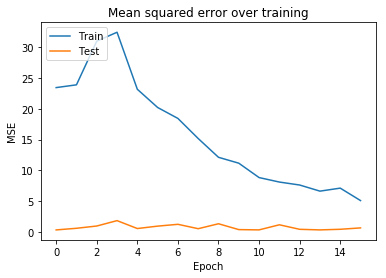

{'num_hidden_layers': [1], 'hidden_layer_size': [256], 'activation_function': ['sigmoid']}


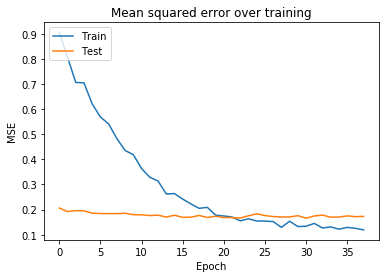

{'num_hidden_layers': [1], 'hidden_layer_size': [128], 'activation_function': ['linear']}


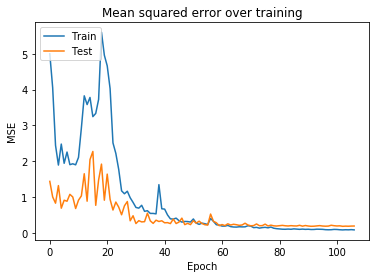

{'num_hidden_layers': [1], 'hidden_layer_size': [64], 'activation_function': ['relu']}


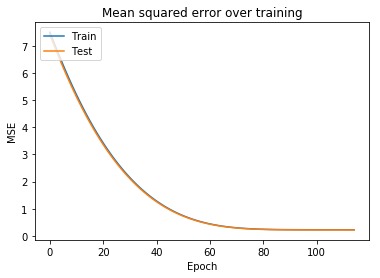

{'num_hidden_layers': [2], 'hidden_layer_size': [64], 'activation_function': ['linear']}


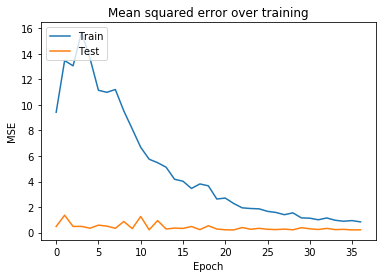

In [62]:
for i, k in enumerate(list(model_info.keys())): 
    print(final_models[i])
    plt.plot(model_info[k]['history']['loss'][2:])
    plt.plot(model_info[k]['history']['val_loss'][2:])
    plt.title('Mean squared error over training')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

The first and third models both show evidence of overfitting, as training performance continued to improve as validation performance plateaued (as seen when the blue line goes below the orange line). This suggests that these models will perform worse on the out-of-sample data.

Now I store and upload the predictions of each model to obtain the results on the true held out data.

In [63]:
for i, k in enumerate(list(model_info.keys())):
    predictions['gpa'] = model_info[k]['preds']
    name = '../output/final_predictions_model_'+str(i)+'.csv'
    predictions.to_csv(name)
    # csvs were then uploaded to the challenge website: https://codalab.fragilefamilieschallenge.org/#participate-submit_results

It is useful to compare to the predicted values for the test data.

In [64]:
# Printing performance on validation set
for k,v in model_info.items():
    print(mean_squared_error(y_test, v['grid_obj'].predict(np.array(X_test))))

0.6346324251893312
0.1728477837956951
0.18892284947139587
0.2186643873589771
0.21609889833913917


In [90]:
# Store all five model objects
for k,v in model_info.items():
    v['keras_model'].save('../output/models/'+k+'.h5')

## Scores on held out challenge set

0.41737 (Submission 27)


0.64386  (Submission 28) Unsurprising since it looks like it didn't have enough time before it stopped and also performed poorly on the test set


0.42533  (Submission 29)


0.43441 (Submission 30)


0.37975 (Submission 31)

The fifth model with 3 hidden layers, each consisting of 256 units, with a sigmoid activation worked best.